In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import rasterio as io




import torch.nn.functional as F



import matplotlib.pyplot as plt
from torch.optim import Optimizer
from torch.nn import Module
from torch.cuda import device as cuda_device
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss
from sklearn.metrics import r2_score
import numpy as np

In [2]:
# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Running on device: {device}')

In [2]:
img_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/train_2"
img_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/val_2"
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/test2"
# img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"

# ann_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2"
# ann_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2"
# ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2"
# ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"

crop_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2/normalized_train_yield.csv"
crop_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2/normalized_val_yield.csv"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2/normalized_test_yield.csv"
# crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"






In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float64)  # Convert input data to double precision
])

In [4]:
# Define dataset class
class CropYieldDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None, mode='train'):
        self.img_dir = img_dir
        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.csv_data.iloc[idx, 1] + ".tif")
        with io.open(img_name) as src:
            image = src.read().astype('float64')  # Read image as float64
        soy_yield_normalized= self.csv_data.iloc[idx, 6]  # First crop yield value
        corn_yield_normalized = self.csv_data.iloc[idx, 7]  # Second crop yield value
        
        if self.transform:
            # image = self.transform(image)
            p=5
        if self.mode == 'test':
            return image, (corn_yield_normalized, soy_yield_normalized)
        else:
            return image,(torch.tensor(corn_yield_normalized, dtype=torch.float64), torch.tensor(soy_yield_normalized, dtype=torch.float64))

In [6]:
# Test on Cansas
# crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test/normalized_test_yield.csv"
# img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test"
# dataset_test = CropYieldDataset(img_dir=img_test, csv_file=crop_test, transform=transform)
# test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNNRegressor().double()
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [5]:
dataset_train = CropYieldDataset(img_dir=img_train, csv_file=crop_train, transform=transform)
dataset_val = CropYieldDataset(img_dir=img_val, csv_file=crop_val, transform=transform)
dataset_test = CropYieldDataset(img_dir=img_test, csv_file=crop_test, transform=transform)


In [6]:
# Move data loaders to GPU
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True, pin_memory=True)
# train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4, collate_fn=None)
# val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=4, collate_fn=None)


In [9]:
# # test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True, pin_memory=True)

# for i ,l in test_loader:
#     print(i.size(0))
#     print(l)
#     # print(i)
#     # print(img_name)
#     break

In [10]:
# train using the sigmoid function

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(8, 128, kernel_size=3, padding=1)  # Input channels set to 8
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        # Define the MaxPooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the flattened features after all conv and pooling layers
        # Pooling layer applied four times, each halves both dimensions: 224 -> 112 -> 56 -> 28 -> 14
        final_dimension = 14  # this is what 224 / 2 / 2 / 2 / 2 evaluates to

        # Define the BatchNormalization for the fully connected layer
        self.batch_norm = nn.BatchNorm1d(64)

        # Define the fully connected layers
        self.fc1 = nn.Linear(32 * final_dimension * final_dimension, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 4)
        
        # Define two separate heads for the output
        self.head1 = nn.Linear(4, 1)
        self.head2 = nn.Linear(4, 1)

        # Define dropout layer
        self.dropout = nn.Dropout(0.5)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply convolutions and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten the output for the dense layers
        x = torch.flatten(x, 1)

        # Apply dense layers with ReLU and dropout
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        # Apply the two separate output heads
        # out1 = self.sigmoid(self.head1(x))
        # out2 = self.sigmoid(self.head2(x))

        out1 = self.head1(x)
        out2 = self.head2(x)
        # Concatenate the outputs from the two heads
        output = torch.cat((out1, out2), dim=1)

        return output

# Example usage
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = CNNRegressor().to(device)


In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNNRegressor().double()
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs!")
#     model = nn.DataParallel(model)
# model = model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming CNNRegressor, train_loader, val_loader, and other necessary elements are defined


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.counter = 0
        self.checkpoint_dir = 'checkpoints_CNN_multi_heads_No_segmoid'

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model and optimizer when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        self.val_loss_min = val_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0
    all_outputs = []
    all_labels = []

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss1 = criterion(outputs[:, 0], labels[:, 0])
        loss2 = criterion(outputs[:, 1], labels[:, 1])
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss1 += loss1.item() * images.size(0)
        running_loss2 += loss2.item() * images.size(0)
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    train_r2_score1 = r2_score(all_labels[:, 0], all_outputs[:, 0])
    train_r2_score2 = r2_score(all_labels[:, 1], all_outputs[:, 1])

    epoch_loss1 = running_loss1 / len(train_loader.dataset)
    epoch_loss2 = running_loss2 / len(train_loader.dataset)
    total_epoch_loss = epoch_loss1 + epoch_loss2

    return epoch_loss1, epoch_loss2, total_epoch_loss, (train_r2_score1, train_r2_score2)

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss1 = 0.0
    val_loss2 = 0.0
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
            outputs = model(images)
            loss1 = criterion(outputs[:, 0], labels[:, 0])
            loss2 = criterion(outputs[:, 1], labels[:, 1])
            val_loss1 += loss1.item() * images.size(0)
            val_loss2 += loss2.item() * images.size(0)
            all_val_outputs.append(outputs.detach().cpu().numpy())
            all_val_labels.append(labels.cpu().numpy())

    all_val_outputs = np.vstack(all_val_outputs)
    all_val_labels = np.vstack(all_val_labels)
    val_r2_score1 = r2_score(all_val_labels[:, 0], all_val_outputs[:, 0])
    val_r2_score2 = r2_score(all_val_labels[:, 1], all_val_outputs[:, 1])

    val_loss1 /= len(val_loader.dataset)
    val_loss2 /= len(val_loader.dataset)
    total_val_loss = val_loss1 + val_loss2

    return val_loss1, val_loss2, total_val_loss, (val_r2_score1, val_r2_score2)

def plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs,base_dir):
    epochs = range(1, num_epochs + 1)
    base_dir = base_dir
    # Plot loss (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses1, 'b-', label='Training loss (Corn)')
    plt.plot(epochs, val_losses1, 'r-', label='Validation loss (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('loss (Corn)')
    plt.legend()
    plt.title('Training and Validation loss (Corn)')
    
    plt.savefig(os.path.join(base_dir, 'loss_corn.png'))
    plt.show()
    
    # Plot Loss (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses2, 'b--', label='Training Loss (Soybeans)')
    plt.plot(epochs, val_losses2, 'r--', label='Validation Loss (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Soybeans)')
    plt.legend()
    plt.title('Training and Validation Loss (Soybeans)')
    
    plt.savefig(os.path.join(base_dir, 'loss_soybean.png'))
    plt.show()
    
    # Plot R² Score (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores1, 'b-', label='Training R² Score (Corn)')
    plt.plot(epochs, val_r2_scores1, 'r-', label='Validation R² Score (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Corn)')
    plt.legend()
    plt.title('Training and Validation R² Score (Corn)')
    
    plt.savefig(os.path.join(base_dir, 'r2_score_corn.png'))
    plt.show()
    
    # Plot R² Score (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores2, 'b--', label='Training R² Score (Soybeans)')
    plt.plot(epochs, val_r2_scores2, 'r--', label='Validation R² Score (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Soybeans)')
    plt.legend()
    plt.title('Training and Validation R² Score (Soybeans)')
 
    plt.savefig(os.path.join(base_dir, 'r2_score_soybean.png'))
    plt.show()



base_dir = 'checkpoints_CNN_multi_heads_No_segmoid'
num_epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNRegressor().double()
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Initialize learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

early_stopper = EarlyStopping(patience=10, verbose=True)


train_losses1, train_losses2, train_losses = [], [], []
val_losses1, val_losses2, val_losses = [],[],[]
train_r2_scores1, train_r2_scores2 = [], []
val_r2_scores1, val_r2_scores2 = [],[]

with open(os.path.join(base_dir, 'CNN_Reg_loss_log_No_segmoid.txt'), 'w') as f:
    f.write("Epoch,Training Loss 1,Training Loss 2,Total Training Loss,Training R^2 Score 1,Training R^2 Score (Soybeans),Validation Loss 1,Validation Loss 2,Total Validation Loss,Validation R^2 Score 1,Validation R^2 Score 2,Learning Rate\n")

    for epoch in range(num_epochs):
        try:
            train_loss1, train_loss2, train_loss, train_r2 = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss1, val_loss2, val_loss, val_r2 = validate_one_epoch(model, val_loader, criterion, device)

            train_losses1.append(train_loss1)
            train_losses2.append(train_loss2)
            train_losses.append(train_loss)
            val_losses1.append(val_loss1)
            val_losses2.append(val_loss2)
            val_losses.append(val_loss)
            train_r2_scores1.append(train_r2[0])
            train_r2_scores2.append(train_r2[1])
            val_r2_scores1.append(val_r2[0])
            val_r2_scores2.append(val_r2[1])

            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']

            f.write(f"{epoch + 1},{train_loss1:.4f},{train_loss2:.4f},{train_loss:.4f},{train_r2[0]:.4f},{train_r2[1]:.4f},{val_loss1:.4f},{val_loss2:.4f},{val_loss:.4f},{val_r2[0]:.4f},{val_r2[1]:.4f},{current_lr:.6f}\n")

            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss (Corn): {train_loss1:.4f}, Training Loss (Soybeans): {train_loss2:.4f}, Total Training Loss: {train_loss:.4f}, Training R^2 Score  (Corn): {train_r2[0]:.4f}, Training R^2 Score (Soybeans): {train_r2[1]:.4f}")
            print(f"Validation Loss (Corn): {val_loss1:.4f}, Validation Loss (Soybeans): {val_loss2:.4f}, Total Validation Loss: {val_loss:.4f}, Validation R^2 Score  (Corn): {val_r2[0]:.4f}, Validation R^2 Score (Soybeans): {val_r2[1]:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
            early_stopper(val_loss, model, optimizer, epoch)
            
            # Step the scheduler
            scheduler.step(val_loss)

            if early_stopper.early_stop:
                print("Early stopping triggered.")
                break
        except Exception as e:
            print(f"Exception occurred: {e}")
            early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
            break

    
    # Plot the metrics



Validation: 100%|██████████| 74/74 [04:17<00:00,  3.48s/it]


Epoch [1/50], Training Loss (Corn): 0.4176, Training Loss (Soybeans): 0.3609, Total Training Loss: 0.7785, Training R^2 Score  (Corn): -9.0880, Training R^2 Score (Soybeans): -10.3599
Validation Loss (Corn): 0.3055, Validation Loss (Soybeans): 0.3372, Total Validation Loss: 0.6427, Validation R^2 Score  (Corn): -6.3547, Validation R^2 Score (Soybeans): -9.4286
Learning Rate: 0.000100
Validation loss decreased (inf --> 0.642663). Saving model ...
Validation loss decreased (0.642663 --> 0.642663). Saving model ...


Validation: 100%|██████████| 74/74 [00:44<00:00,  1.66it/s]


Epoch [2/50], Training Loss (Corn): 0.2268, Training Loss (Soybeans): 0.2824, Total Training Loss: 0.5092, Training R^2 Score  (Corn): -4.4775, Training R^2 Score (Soybeans): -7.8910
Validation Loss (Corn): 0.0435, Validation Loss (Soybeans): 0.1918, Total Validation Loss: 0.2353, Validation R^2 Score  (Corn): -0.0465, Validation R^2 Score (Soybeans): -4.9328
Learning Rate: 0.000100
Validation loss decreased (0.642663 --> 0.235297). Saving model ...
Validation loss decreased (0.235297 --> 0.235297). Saving model ...


Validation: 100%|██████████| 74/74 [00:42<00:00,  1.73it/s]


Epoch [3/50], Training Loss (Corn): 0.0595, Training Loss (Soybeans): 0.1051, Total Training Loss: 0.1646, Training R^2 Score  (Corn): -0.4368, Training R^2 Score (Soybeans): -2.3090
Validation Loss (Corn): 0.2007, Validation Loss (Soybeans): 0.0522, Total Validation Loss: 0.2529, Validation R^2 Score  (Corn): -3.8333, Validation R^2 Score (Soybeans): -0.6133
Learning Rate: 0.000100
Validation loss decreased (0.235297 --> 0.252904). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:42<00:00,  1.73it/s]


Epoch [4/50], Training Loss (Corn): 0.0269, Training Loss (Soybeans): 0.0304, Total Training Loss: 0.0573, Training R^2 Score  (Corn): 0.3503, Training R^2 Score (Soybeans): 0.0443
Validation Loss (Corn): 0.0097, Validation Loss (Soybeans): 0.0265, Total Validation Loss: 0.0361, Validation R^2 Score  (Corn): 0.7673, Validation R^2 Score (Soybeans): 0.1810
Learning Rate: 0.000100
Validation loss decreased (0.252904 --> 0.036147). Saving model ...
Validation loss decreased (0.036147 --> 0.036147). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [5/50], Training Loss (Corn): 0.0242, Training Loss (Soybeans): 0.0263, Total Training Loss: 0.0506, Training R^2 Score  (Corn): 0.4149, Training R^2 Score (Soybeans): 0.1707
Validation Loss (Corn): 0.1336, Validation Loss (Soybeans): 0.0578, Total Validation Loss: 0.1914, Validation R^2 Score  (Corn): -2.2163, Validation R^2 Score (Soybeans): -0.7869
Learning Rate: 0.000100
Validation loss decreased (0.036147 --> 0.191358). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:42<00:00,  1.73it/s]


Epoch [6/50], Training Loss (Corn): 0.0223, Training Loss (Soybeans): 0.0230, Total Training Loss: 0.0454, Training R^2 Score  (Corn): 0.4603, Training R^2 Score (Soybeans): 0.2751
Validation Loss (Corn): 0.1607, Validation Loss (Soybeans): 0.0917, Total Validation Loss: 0.2524, Validation R^2 Score  (Corn): -2.8703, Validation R^2 Score (Soybeans): -1.8345
Learning Rate: 0.000100
Validation loss decreased (0.191358 --> 0.252396). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [7/50], Training Loss (Corn): 0.0212, Training Loss (Soybeans): 0.0205, Total Training Loss: 0.0417, Training R^2 Score  (Corn): 0.4875, Training R^2 Score (Soybeans): 0.3541
Validation Loss (Corn): 0.0369, Validation Loss (Soybeans): 0.1248, Total Validation Loss: 0.1617, Validation R^2 Score  (Corn): 0.1124, Validation R^2 Score (Soybeans): -2.8592
Learning Rate: 0.000100
Validation loss decreased (0.252396 --> 0.161651). Saving model ...
EarlyStopping counter: 3 out of 10


Validation: 100%|██████████| 74/74 [00:42<00:00,  1.73it/s]


Epoch [8/50], Training Loss (Corn): 0.0200, Training Loss (Soybeans): 0.0195, Total Training Loss: 0.0395, Training R^2 Score  (Corn): 0.5169, Training R^2 Score (Soybeans): 0.3859
Validation Loss (Corn): 0.0104, Validation Loss (Soybeans): 0.0130, Total Validation Loss: 0.0234, Validation R^2 Score  (Corn): 0.7489, Validation R^2 Score (Soybeans): 0.5992
Learning Rate: 0.000100
Validation loss decreased (0.161651 --> 0.023388). Saving model ...
Validation loss decreased (0.023388 --> 0.023388). Saving model ...


Validation: 100%|██████████| 74/74 [00:42<00:00,  1.72it/s]


Epoch [9/50], Training Loss (Corn): 0.0194, Training Loss (Soybeans): 0.0185, Total Training Loss: 0.0379, Training R^2 Score  (Corn): 0.5305, Training R^2 Score (Soybeans): 0.4186
Validation Loss (Corn): 0.0090, Validation Loss (Soybeans): 0.0407, Total Validation Loss: 0.0497, Validation R^2 Score  (Corn): 0.7837, Validation R^2 Score (Soybeans): -0.2601
Learning Rate: 0.000100
Validation loss decreased (0.023388 --> 0.049728). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.72it/s]


Epoch [10/50], Training Loss (Corn): 0.0183, Training Loss (Soybeans): 0.0168, Total Training Loss: 0.0352, Training R^2 Score  (Corn): 0.5569, Training R^2 Score (Soybeans): 0.4704
Validation Loss (Corn): 0.1159, Validation Loss (Soybeans): 0.0923, Total Validation Loss: 0.2082, Validation R^2 Score  (Corn): -1.7901, Validation R^2 Score (Soybeans): -1.8543
Learning Rate: 0.000100
Validation loss decreased (0.049728 --> 0.208173). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [11/50], Training Loss (Corn): 0.0180, Training Loss (Soybeans): 0.0166, Total Training Loss: 0.0345, Training R^2 Score  (Corn): 0.5656, Training R^2 Score (Soybeans): 0.4789
Validation Loss (Corn): 0.0809, Validation Loss (Soybeans): 0.0367, Total Validation Loss: 0.1176, Validation R^2 Score  (Corn): -0.9473, Validation R^2 Score (Soybeans): -0.1349
Learning Rate: 0.000100
Validation loss decreased (0.208173 --> 0.117572). Saving model ...
EarlyStopping counter: 3 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.69it/s]


Epoch [12/50], Training Loss (Corn): 0.0164, Training Loss (Soybeans): 0.0148, Total Training Loss: 0.0312, Training R^2 Score  (Corn): 0.6044, Training R^2 Score (Soybeans): 0.5347
Validation Loss (Corn): 0.0335, Validation Loss (Soybeans): 0.3106, Total Validation Loss: 0.3441, Validation R^2 Score  (Corn): 0.1933, Validation R^2 Score (Soybeans): -8.6067
Learning Rate: 0.000100
Validation loss decreased (0.117572 --> 0.344133). Saving model ...
EarlyStopping counter: 4 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [13/50], Training Loss (Corn): 0.0166, Training Loss (Soybeans): 0.0143, Total Training Loss: 0.0309, Training R^2 Score  (Corn): 0.5997, Training R^2 Score (Soybeans): 0.5485
Validation Loss (Corn): 0.0065, Validation Loss (Soybeans): 0.0196, Total Validation Loss: 0.0261, Validation R^2 Score  (Corn): 0.8430, Validation R^2 Score (Soybeans): 0.3938
Learning Rate: 0.000100
Validation loss decreased (0.344133 --> 0.026122). Saving model ...
EarlyStopping counter: 5 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [14/50], Training Loss (Corn): 0.0146, Training Loss (Soybeans): 0.0136, Total Training Loss: 0.0282, Training R^2 Score  (Corn): 0.6464, Training R^2 Score (Soybeans): 0.5734
Validation Loss (Corn): 0.1210, Validation Loss (Soybeans): 1.1016, Total Validation Loss: 1.2226, Validation R^2 Score  (Corn): -1.9136, Validation R^2 Score (Soybeans): -33.0683
Learning Rate: 0.000100
Validation loss decreased (0.026122 --> 1.222603). Saving model ...
EarlyStopping counter: 6 out of 10
Epoch 00014: reducing learning rate of group 0 to 1.0000e-05.


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [15/50], Training Loss (Corn): 0.0146, Training Loss (Soybeans): 0.0126, Total Training Loss: 0.0272, Training R^2 Score  (Corn): 0.6484, Training R^2 Score (Soybeans): 0.6019
Validation Loss (Corn): 0.0068, Validation Loss (Soybeans): 0.0178, Total Validation Loss: 0.0246, Validation R^2 Score  (Corn): 0.8365, Validation R^2 Score (Soybeans): 0.4500
Learning Rate: 0.000010
Validation loss decreased (1.222603 --> 0.024577). Saving model ...
EarlyStopping counter: 7 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [16/50], Training Loss (Corn): 0.0135, Training Loss (Soybeans): 0.0116, Total Training Loss: 0.0251, Training R^2 Score  (Corn): 0.6740, Training R^2 Score (Soybeans): 0.6351
Validation Loss (Corn): 0.0061, Validation Loss (Soybeans): 0.0084, Total Validation Loss: 0.0145, Validation R^2 Score  (Corn): 0.8521, Validation R^2 Score (Soybeans): 0.7412
Learning Rate: 0.000010
Validation loss decreased (0.024577 --> 0.014510). Saving model ...
Validation loss decreased (0.014510 --> 0.014510). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [17/50], Training Loss (Corn): 0.0138, Training Loss (Soybeans): 0.0116, Total Training Loss: 0.0255, Training R^2 Score  (Corn): 0.6658, Training R^2 Score (Soybeans): 0.6335
Validation Loss (Corn): 0.0048, Validation Loss (Soybeans): 0.0082, Total Validation Loss: 0.0130, Validation R^2 Score  (Corn): 0.8835, Validation R^2 Score (Soybeans): 0.7479
Learning Rate: 0.000010
Validation loss decreased (0.014510 --> 0.012988). Saving model ...
Validation loss decreased (0.012988 --> 0.012988). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [18/50], Training Loss (Corn): 0.0129, Training Loss (Soybeans): 0.0113, Total Training Loss: 0.0242, Training R^2 Score  (Corn): 0.6886, Training R^2 Score (Soybeans): 0.6444
Validation Loss (Corn): 0.0104, Validation Loss (Soybeans): 0.0064, Total Validation Loss: 0.0168, Validation R^2 Score  (Corn): 0.7494, Validation R^2 Score (Soybeans): 0.8023
Learning Rate: 0.000010
Validation loss decreased (0.012988 --> 0.016802). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [19/50], Training Loss (Corn): 0.0128, Training Loss (Soybeans): 0.0115, Total Training Loss: 0.0243, Training R^2 Score  (Corn): 0.6901, Training R^2 Score (Soybeans): 0.6394
Validation Loss (Corn): 0.0102, Validation Loss (Soybeans): 0.0063, Total Validation Loss: 0.0165, Validation R^2 Score  (Corn): 0.7533, Validation R^2 Score (Soybeans): 0.8054
Learning Rate: 0.000010
Validation loss decreased (0.016802 --> 0.016540). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [20/50], Training Loss (Corn): 0.0133, Training Loss (Soybeans): 0.0118, Total Training Loss: 0.0251, Training R^2 Score  (Corn): 0.6780, Training R^2 Score (Soybeans): 0.6285
Validation Loss (Corn): 0.0055, Validation Loss (Soybeans): 0.0068, Total Validation Loss: 0.0122, Validation R^2 Score  (Corn): 0.8687, Validation R^2 Score (Soybeans): 0.7911
Learning Rate: 0.000010
Validation loss decreased (0.016540 --> 0.012207). Saving model ...
Validation loss decreased (0.012207 --> 0.012207). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.71it/s]


Epoch [21/50], Training Loss (Corn): 0.0131, Training Loss (Soybeans): 0.0115, Total Training Loss: 0.0246, Training R^2 Score  (Corn): 0.6840, Training R^2 Score (Soybeans): 0.6388
Validation Loss (Corn): 0.0085, Validation Loss (Soybeans): 0.0069, Total Validation Loss: 0.0155, Validation R^2 Score  (Corn): 0.7947, Validation R^2 Score (Soybeans): 0.7856
Learning Rate: 0.000010
Validation loss decreased (0.012207 --> 0.015460). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [22/50], Training Loss (Corn): 0.0129, Training Loss (Soybeans): 0.0121, Total Training Loss: 0.0250, Training R^2 Score  (Corn): 0.6881, Training R^2 Score (Soybeans): 0.6204
Validation Loss (Corn): 0.0069, Validation Loss (Soybeans): 0.0062, Total Validation Loss: 0.0131, Validation R^2 Score  (Corn): 0.8342, Validation R^2 Score (Soybeans): 0.8076
Learning Rate: 0.000010
Validation loss decreased (0.015460 --> 0.013111). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [23/50], Training Loss (Corn): 0.0127, Training Loss (Soybeans): 0.0110, Total Training Loss: 0.0237, Training R^2 Score  (Corn): 0.6936, Training R^2 Score (Soybeans): 0.6542
Validation Loss (Corn): 0.0065, Validation Loss (Soybeans): 0.0086, Total Validation Loss: 0.0151, Validation R^2 Score  (Corn): 0.8429, Validation R^2 Score (Soybeans): 0.7352
Learning Rate: 0.000010
Validation loss decreased (0.013111 --> 0.015090). Saving model ...
EarlyStopping counter: 3 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.69it/s]


Epoch [24/50], Training Loss (Corn): 0.0121, Training Loss (Soybeans): 0.0111, Total Training Loss: 0.0232, Training R^2 Score  (Corn): 0.7076, Training R^2 Score (Soybeans): 0.6507
Validation Loss (Corn): 0.0037, Validation Loss (Soybeans): 0.0072, Total Validation Loss: 0.0109, Validation R^2 Score  (Corn): 0.9108, Validation R^2 Score (Soybeans): 0.7774
Learning Rate: 0.000010
Validation loss decreased (0.015090 --> 0.010905). Saving model ...
Validation loss decreased (0.010905 --> 0.010905). Saving model ...


Validation: 100%|██████████| 74/74 [00:44<00:00,  1.68it/s]


Epoch [25/50], Training Loss (Corn): 0.0120, Training Loss (Soybeans): 0.0112, Total Training Loss: 0.0232, Training R^2 Score  (Corn): 0.7092, Training R^2 Score (Soybeans): 0.6481
Validation Loss (Corn): 0.0042, Validation Loss (Soybeans): 0.0117, Total Validation Loss: 0.0158, Validation R^2 Score  (Corn): 0.8997, Validation R^2 Score (Soybeans): 0.6395
Learning Rate: 0.000010
Validation loss decreased (0.010905 --> 0.015822). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.69it/s]


Epoch [26/50], Training Loss (Corn): 0.0123, Training Loss (Soybeans): 0.0114, Total Training Loss: 0.0238, Training R^2 Score  (Corn): 0.7022, Training R^2 Score (Soybeans): 0.6400
Validation Loss (Corn): 0.0037, Validation Loss (Soybeans): 0.0063, Total Validation Loss: 0.0100, Validation R^2 Score  (Corn): 0.9116, Validation R^2 Score (Soybeans): 0.8039
Learning Rate: 0.000010
Validation loss decreased (0.015822 --> 0.010014). Saving model ...
Validation loss decreased (0.010014 --> 0.010014). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [27/50], Training Loss (Corn): 0.0127, Training Loss (Soybeans): 0.0110, Total Training Loss: 0.0237, Training R^2 Score  (Corn): 0.6927, Training R^2 Score (Soybeans): 0.6551
Validation Loss (Corn): 0.0037, Validation Loss (Soybeans): 0.0062, Total Validation Loss: 0.0099, Validation R^2 Score  (Corn): 0.9113, Validation R^2 Score (Soybeans): 0.8079
Learning Rate: 0.000010
Validation loss decreased (0.010014 --> 0.009896). Saving model ...
Validation loss decreased (0.009896 --> 0.009896). Saving model ...


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [28/50], Training Loss (Corn): 0.0115, Training Loss (Soybeans): 0.0108, Total Training Loss: 0.0223, Training R^2 Score  (Corn): 0.7217, Training R^2 Score (Soybeans): 0.6602
Validation Loss (Corn): 0.0048, Validation Loss (Soybeans): 0.0106, Total Validation Loss: 0.0154, Validation R^2 Score  (Corn): 0.8838, Validation R^2 Score (Soybeans): 0.6727
Learning Rate: 0.000010
Validation loss decreased (0.009896 --> 0.015410). Saving model ...
EarlyStopping counter: 1 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [29/50], Training Loss (Corn): 0.0122, Training Loss (Soybeans): 0.0111, Total Training Loss: 0.0232, Training R^2 Score  (Corn): 0.7058, Training R^2 Score (Soybeans): 0.6518
Validation Loss (Corn): 0.0078, Validation Loss (Soybeans): 0.0058, Total Validation Loss: 0.0136, Validation R^2 Score  (Corn): 0.8130, Validation R^2 Score (Soybeans): 0.8207
Learning Rate: 0.000010
Validation loss decreased (0.015410 --> 0.013565). Saving model ...
EarlyStopping counter: 2 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [30/50], Training Loss (Corn): 0.0117, Training Loss (Soybeans): 0.0105, Total Training Loss: 0.0223, Training R^2 Score  (Corn): 0.7167, Training R^2 Score (Soybeans): 0.6688
Validation Loss (Corn): 0.0055, Validation Loss (Soybeans): 0.0059, Total Validation Loss: 0.0114, Validation R^2 Score  (Corn): 0.8684, Validation R^2 Score (Soybeans): 0.8174
Learning Rate: 0.000010
Validation loss decreased (0.013565 --> 0.011370). Saving model ...
EarlyStopping counter: 3 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [31/50], Training Loss (Corn): 0.0123, Training Loss (Soybeans): 0.0104, Total Training Loss: 0.0228, Training R^2 Score  (Corn): 0.7018, Training R^2 Score (Soybeans): 0.6714
Validation Loss (Corn): 0.0040, Validation Loss (Soybeans): 0.0292, Total Validation Loss: 0.0331, Validation R^2 Score  (Corn): 0.9046, Validation R^2 Score (Soybeans): 0.0974
Learning Rate: 0.000010
Validation loss decreased (0.011370 --> 0.033147). Saving model ...
EarlyStopping counter: 4 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.70it/s]


Epoch [32/50], Training Loss (Corn): 0.0122, Training Loss (Soybeans): 0.0103, Total Training Loss: 0.0225, Training R^2 Score  (Corn): 0.7063, Training R^2 Score (Soybeans): 0.6757
Validation Loss (Corn): 0.0055, Validation Loss (Soybeans): 0.0072, Total Validation Loss: 0.0127, Validation R^2 Score  (Corn): 0.8679, Validation R^2 Score (Soybeans): 0.7777
Learning Rate: 0.000010
Validation loss decreased (0.033147 --> 0.012674). Saving model ...
EarlyStopping counter: 5 out of 10


Validation: 100%|██████████| 74/74 [00:44<00:00,  1.68it/s]


Epoch [33/50], Training Loss (Corn): 0.0116, Training Loss (Soybeans): 0.0109, Total Training Loss: 0.0225, Training R^2 Score  (Corn): 0.7195, Training R^2 Score (Soybeans): 0.6568
Validation Loss (Corn): 0.0056, Validation Loss (Soybeans): 0.0060, Total Validation Loss: 0.0116, Validation R^2 Score  (Corn): 0.8662, Validation R^2 Score (Soybeans): 0.8145
Learning Rate: 0.000010
Validation loss decreased (0.012674 --> 0.011556). Saving model ...
EarlyStopping counter: 6 out of 10
Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.68it/s]


Epoch [34/50], Training Loss (Corn): 0.0113, Training Loss (Soybeans): 0.0108, Total Training Loss: 0.0221, Training R^2 Score  (Corn): 0.7277, Training R^2 Score (Soybeans): 0.6598
Validation Loss (Corn): 0.0059, Validation Loss (Soybeans): 0.0069, Total Validation Loss: 0.0128, Validation R^2 Score  (Corn): 0.8587, Validation R^2 Score (Soybeans): 0.7851
Learning Rate: 0.000001
Validation loss decreased (0.011556 --> 0.012816). Saving model ...
EarlyStopping counter: 7 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.69it/s]


Epoch [35/50], Training Loss (Corn): 0.0110, Training Loss (Soybeans): 0.0104, Total Training Loss: 0.0214, Training R^2 Score  (Corn): 0.7340, Training R^2 Score (Soybeans): 0.6727
Validation Loss (Corn): 0.0041, Validation Loss (Soybeans): 0.0080, Total Validation Loss: 0.0121, Validation R^2 Score  (Corn): 0.9015, Validation R^2 Score (Soybeans): 0.7537
Learning Rate: 0.000001
Validation loss decreased (0.012816 --> 0.012054). Saving model ...
EarlyStopping counter: 8 out of 10


Validation: 100%|██████████| 74/74 [00:43<00:00,  1.69it/s]


Epoch [36/50], Training Loss (Corn): 0.0111, Training Loss (Soybeans): 0.0105, Total Training Loss: 0.0216, Training R^2 Score  (Corn): 0.7308, Training R^2 Score (Soybeans): 0.6694
Validation Loss (Corn): 0.0041, Validation Loss (Soybeans): 0.0082, Total Validation Loss: 0.0123, Validation R^2 Score  (Corn): 0.9005, Validation R^2 Score (Soybeans): 0.7473
Learning Rate: 0.000001
Validation loss decreased (0.012054 --> 0.012303). Saving model ...
EarlyStopping counter: 9 out of 10


Validation: 100%|██████████| 74/74 [00:44<00:00,  1.67it/s]

Epoch [37/50], Training Loss (Corn): 0.0116, Training Loss (Soybeans): 0.0100, Total Training Loss: 0.0216, Training R^2 Score  (Corn): 0.7193, Training R^2 Score (Soybeans): 0.6853
Validation Loss (Corn): 0.0039, Validation Loss (Soybeans): 0.0070, Total Validation Loss: 0.0110, Validation R^2 Score  (Corn): 0.9060, Validation R^2 Score (Soybeans): 0.7820
Learning Rate: 0.000001
Validation loss decreased (0.012303 --> 0.010953). Saving model ...
EarlyStopping counter: 10 out of 10
Early stopping triggered.


In [9]:
num_epochs = 37

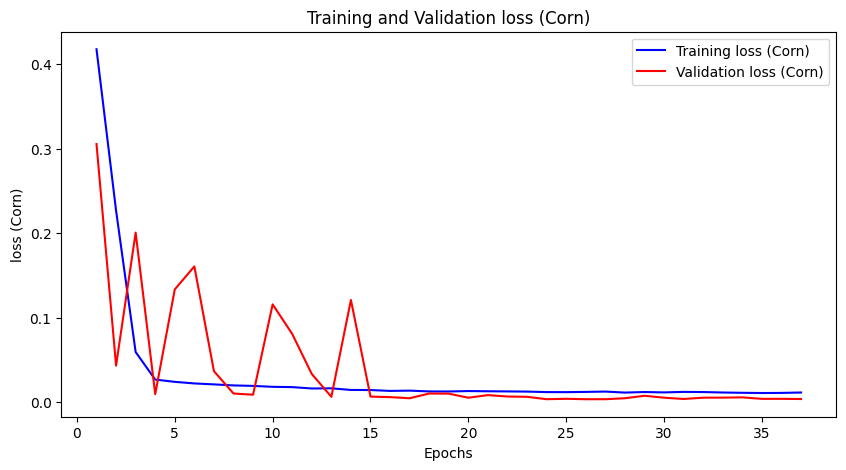

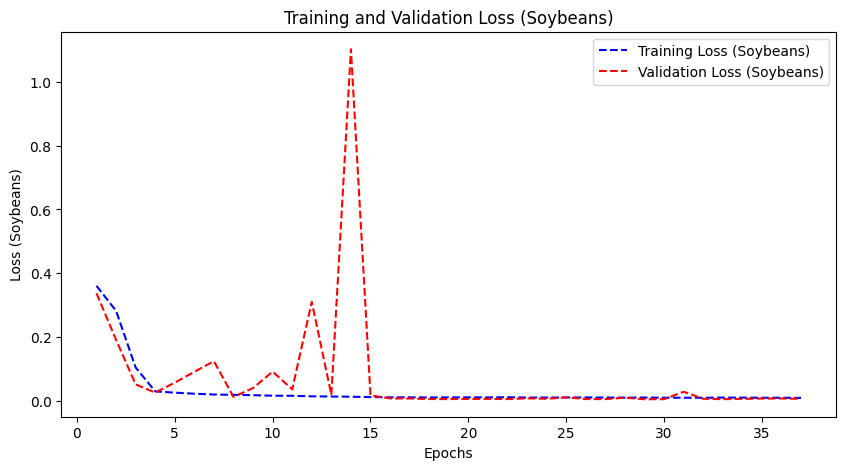

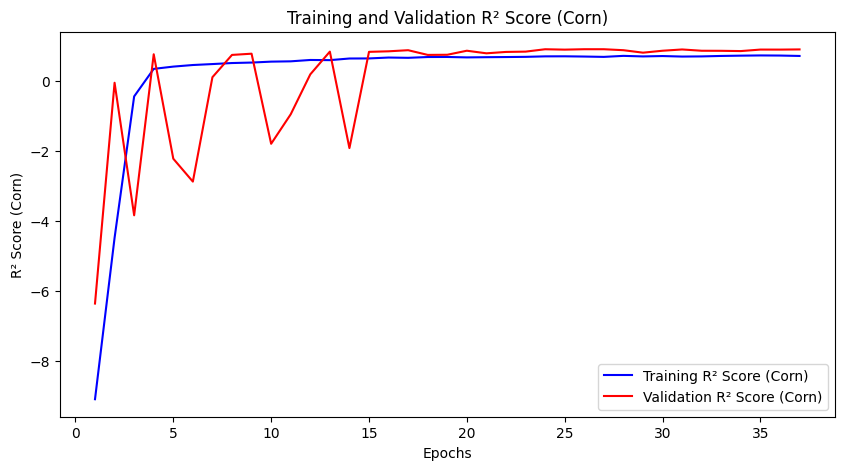

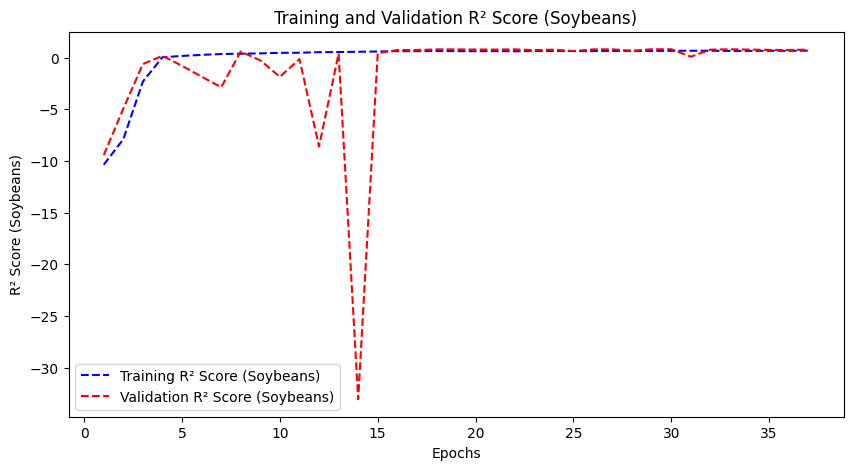

In [10]:
plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs,base_dir)


In [8]:
# Test on MN22

Test Loss (Corn): 0.0103, Test Loss (Soybeans): 0.0118, Total Test Loss: 0.0221
Test R^2 Score (Corn): 0.7720, Test R^2 Score (Soybeans): 0.5501


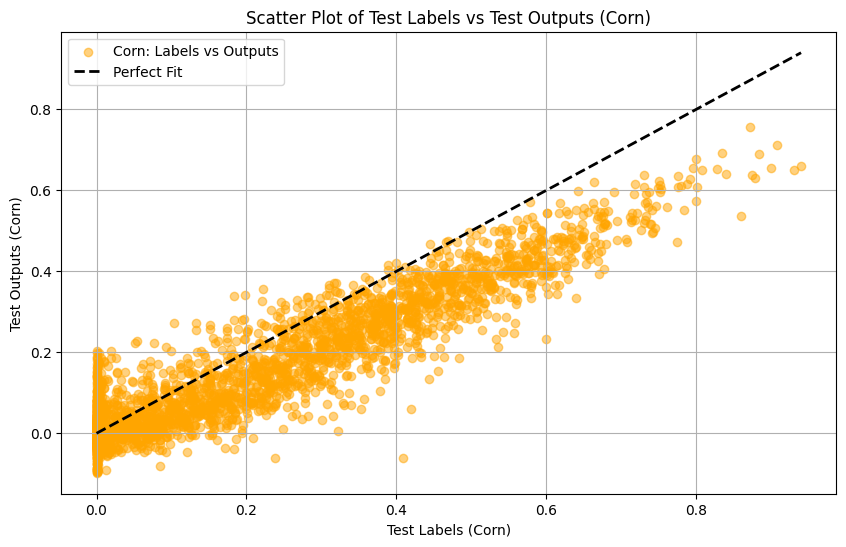

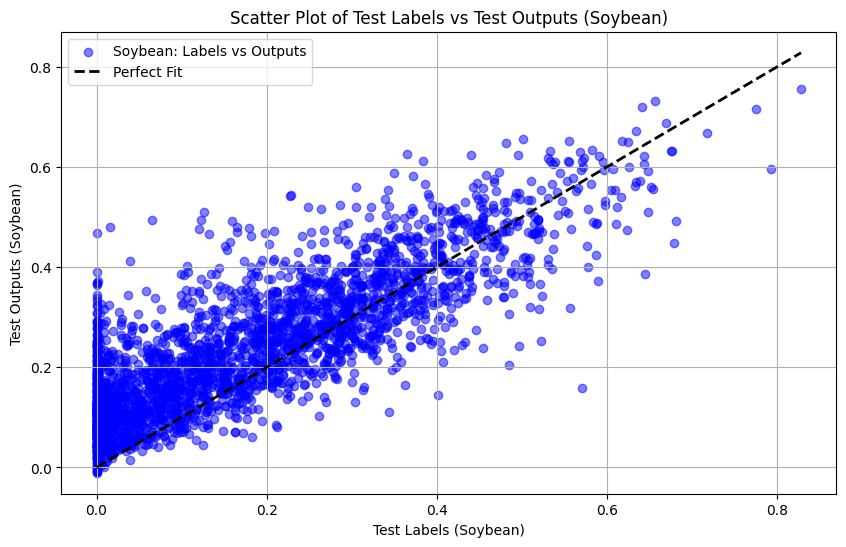

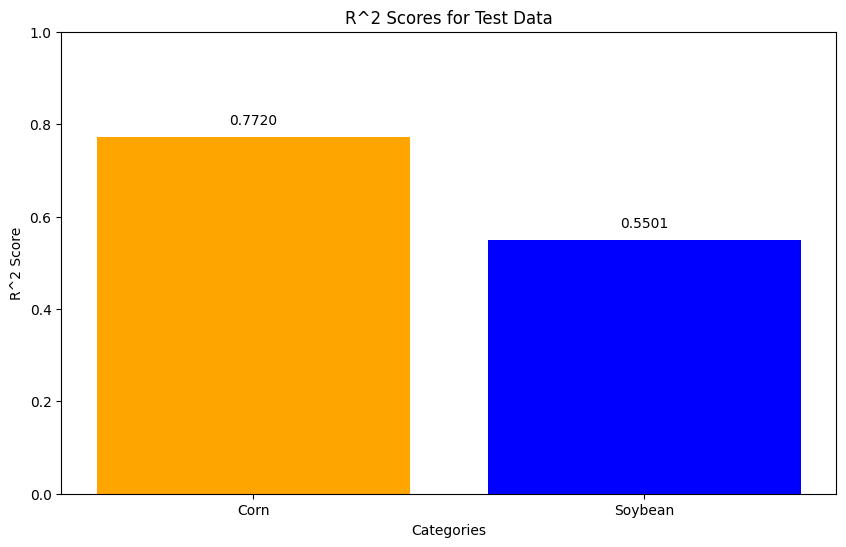

In [12]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    # Save the labels and outputs to a CSV file
    df = pd.DataFrame({
        'Test Labels Corn': all_test_labels[:, 0],
        'Test Outputs Corn': all_test_outputs[:, 0],
        'Test Labels Soybean': all_test_labels[:, 1],
        'Test Outputs Soybean': all_test_outputs[:, 1]
    })
    df.to_csv('predictions_CNN__No_Sig_MN22.csv', index=False)

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_multi_heads_No_segmoid'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads_No_segmoid/checkpoint_epoch_20.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


In [ ]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_multi_heads_segmoid'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads_segmoid/checkpoint_epoch_49.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


Test Loss (Corn): 0.0140, Test Loss (Soybeans): 0.0106, Total Test Loss: 0.0246
Test R^2 Score (Corn): 0.6911, Test R^2 Score (Soybeans): 0.5943


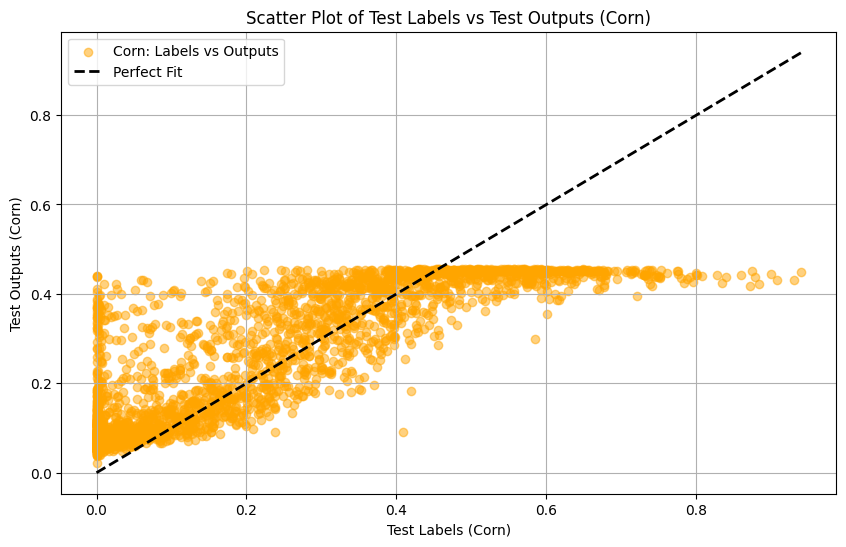

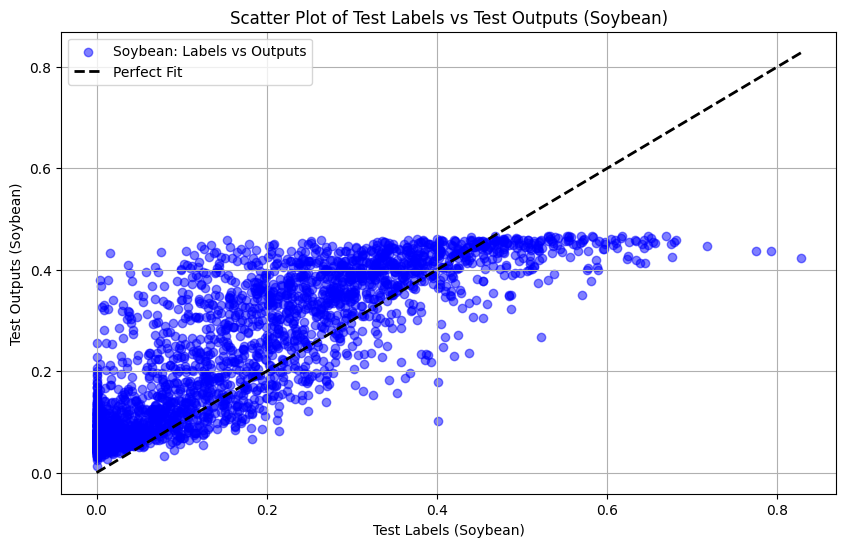

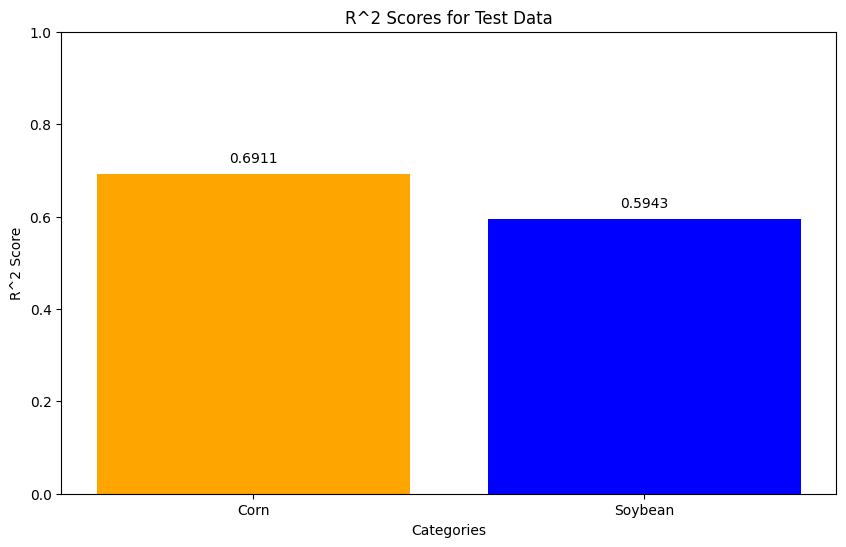

In [13]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Index': indices,
        'True_Corn_Yield': all_test_labels[:,0],
        'Predicted_Corn_Yield': all_test_outputs[:,0],
        'True_Soybean_Yield': all_test_labels[:,1],
        'Predicted_Soybean_Yield': all_test_outputs[:,1]
    })
    results_df.to_csv('predictions.csv', index=False)

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_multi_heads_segmoid'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads_segmoid/checkpoint_epoch_49.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


In [15]:
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"
dataset_test = CropYieldDataset(img_test,crop_test, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)


Test Loss (Corn): 0.0085, Test Loss (Soybeans): 0.0206, Total Test Loss: 0.0292
Test R^2 Score (Corn): 0.7777, Test R^2 Score (Soybeans): -0.0355


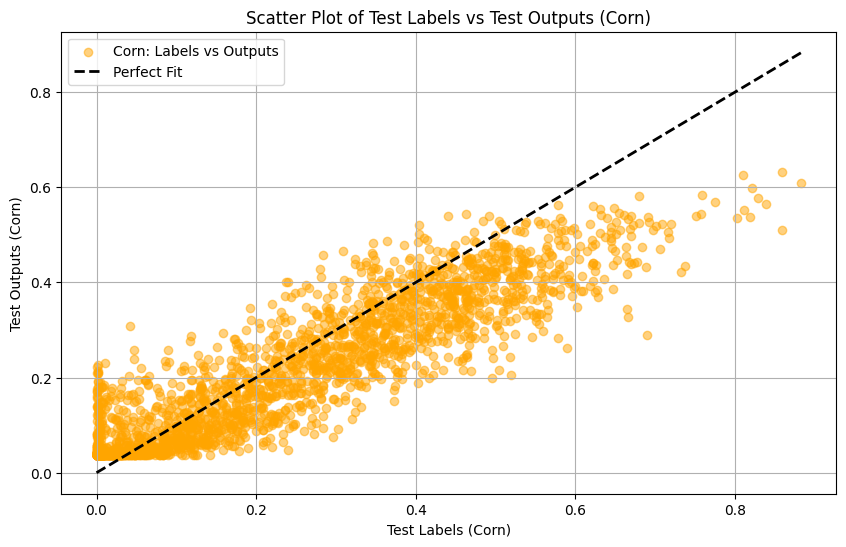

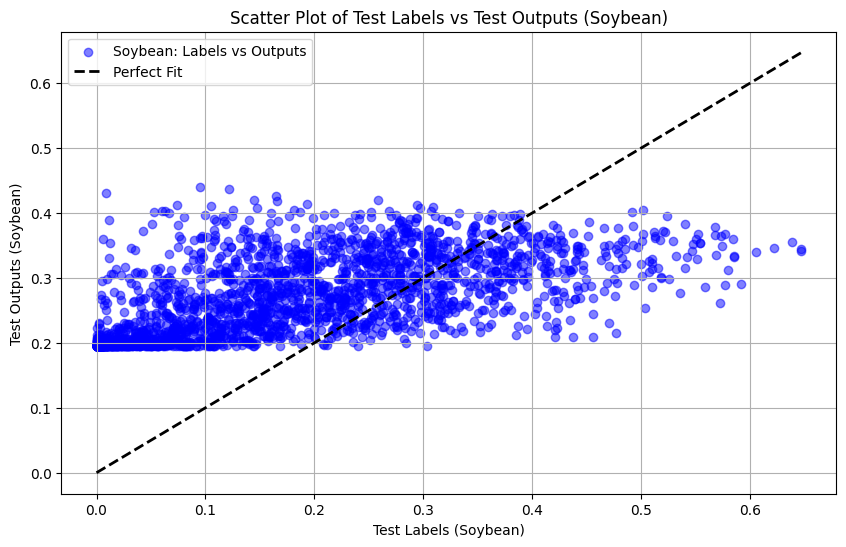

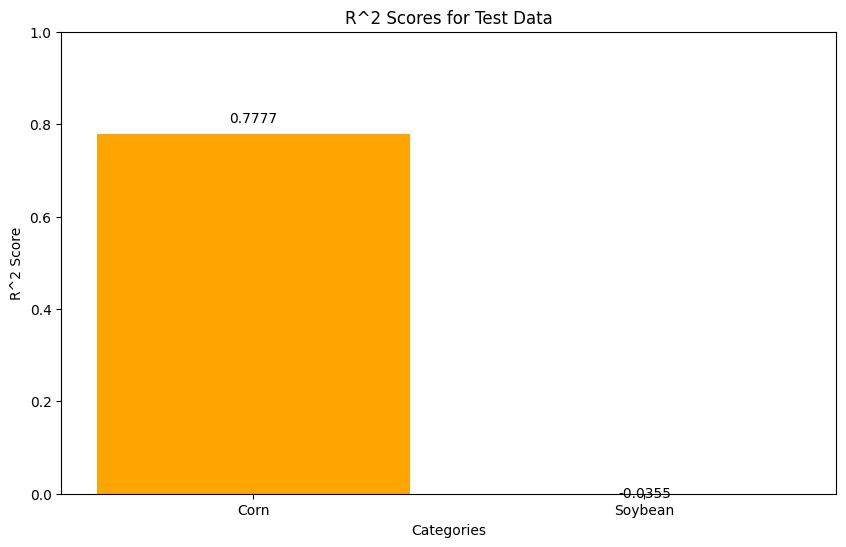

In [16]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_multi_heads_lr_00001'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads_lr_00001/checkpoint_epoch_17.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


In [19]:
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"
dataset_test = CropYieldDataset(img_test,crop_test, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)


Test Loss (Corn): 0.0085, Test Loss (Soybeans): 0.0116, Total Test Loss: 0.0201
Test R^2 Score (Corn): 0.7780, Test R^2 Score (Soybeans): 0.4204


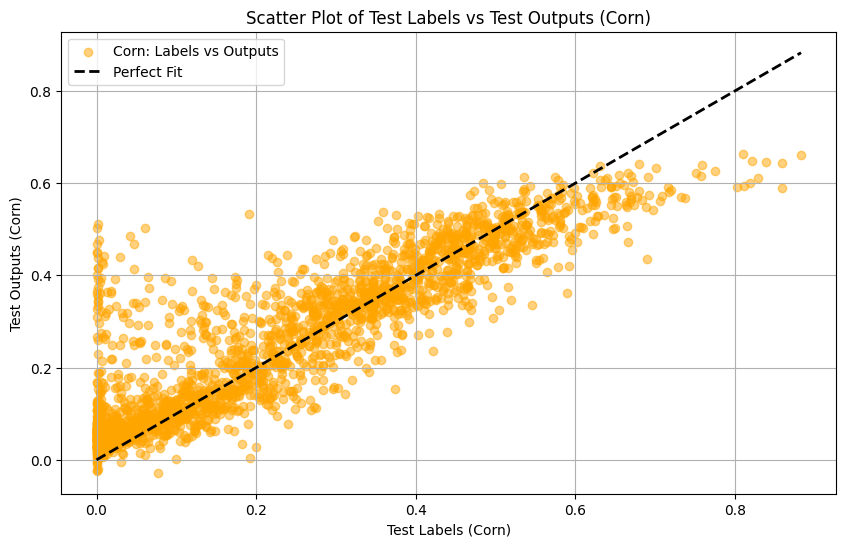

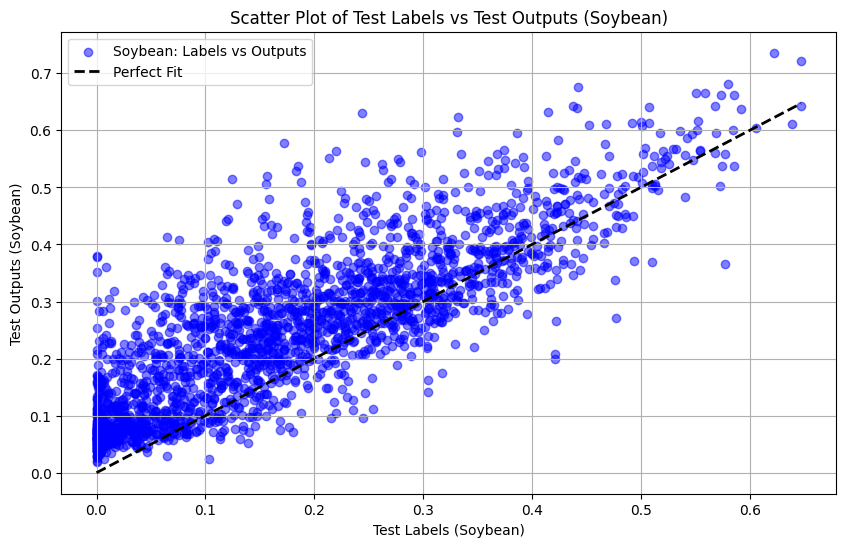

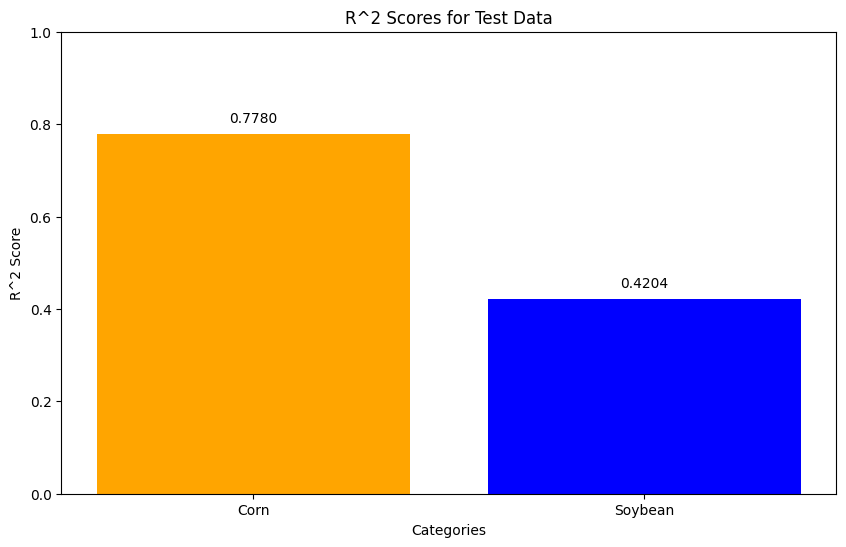

In [20]:
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

import os

def plot_test_results(all_test_labels, all_test_outputs):
    # base_dir = 'checkpoints_CNN_multi_heads2'
    os.makedirs(base_dir, exist_ok=True)

    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='orange', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_corn6.png'))
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='blue', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, 'test_labels_vs_outputs_soybean6.png'))
    plt.show()

def plot_r2_scores(test_r2_score1, test_r2_score2):
    # base_dir = 'checkpoints_CNN_multi_heads'
    os.makedirs(base_dir, exist_ok=True)

    categories = ['Corn', 'Soybean']
    r2_scores = [test_r2_score1, test_r2_score2]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Categories')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Scores for Test Data')
    plt.ylim(0, 1)  # Assuming R^2 scores are between 0 and 1
    
    # Add the R^2 score values on top of the bars
    for bar, r2_score in zip(bars, r2_scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{r2_score:.4f}', ha='center', va='bottom')

    plt.savefig(os.path.join(base_dir, 'test_r2_scores6.png'))
    plt.show()

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict


base_dir = 'checkpoints_CNN_multi_heads_final'


# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads_final/checkpoint_epoch_30.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
plot_r2_scores(test_r2_score1, test_r2_score2)


Using 4 GPUs!


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Epoch [1/50], Training Loss 1: 0.0408, Training Loss 2: 0.0753, Total Training Loss: 0.1160, Training R^2 Score 1: 0.0264, Training R^2 Score 2: -1.3258
Validation Loss 1: 0.0479, Validation Loss 2: 0.0548, Total Validation Loss: 0.1027, Validation R^2 Score 1: -0.7459, Validation R^2 Score 2: -0.8890
Learning Rate: 0.000100
Validation loss decreased (inf --> 0.102731). Saving model ...
Validation loss decreased (0.102731 --> 0.102731). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [2/50], Training Loss 1: 0.0369, Training Loss 2: 0.0709, Total Training Loss: 0.1079, Training R^2 Score 1: 0.1179, Training R^2 Score 2: -1.1915
Validation Loss 1: 0.0441, Validation Loss 2: 0.0509, Total Validation Loss: 0.0950, Validation R^2 Score 1: -0.6080, Validation R^2 Score 2: -0.7520
Learning Rate: 0.000100
Validation loss decreased (0.102731 --> 0.094973). Saving model ...
Validation loss decreased (0.094973 --> 0.094973). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch [3/50], Training Loss 1: 0.0333, Training Loss 2: 0.0656, Total Training Loss: 0.0990, Training R^2 Score 1: 0.2039, Training R^2 Score 2: -1.0278
Validation Loss 1: 0.0411, Validation Loss 2: 0.0477, Total Validation Loss: 0.0888, Validation R^2 Score 1: -0.4992, Validation R^2 Score 2: -0.6421
Learning Rate: 0.000100
Validation loss decreased (0.094973 --> 0.088797). Saving model ...
Validation loss decreased (0.088797 --> 0.088797). Saving model ...


Validation: 100%|██████████| 14/14 [00:16<00:00,  1.20s/it]


Epoch [4/50], Training Loss 1: 0.0294, Training Loss 2: 0.0591, Total Training Loss: 0.0885, Training R^2 Score 1: 0.2969, Training R^2 Score 2: -0.8256
Validation Loss 1: 0.0377, Validation Loss 2: 0.0426, Total Validation Loss: 0.0803, Validation R^2 Score 1: -0.3760, Validation R^2 Score 2: -0.4663
Learning Rate: 0.000100
Validation loss decreased (0.088797 --> 0.080315). Saving model ...
Validation loss decreased (0.080315 --> 0.080315). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch [5/50], Training Loss 1: 0.0256, Training Loss 2: 0.0507, Total Training Loss: 0.0763, Training R^2 Score 1: 0.3882, Training R^2 Score 2: -0.5675
Validation Loss 1: 0.0373, Validation Loss 2: 0.0377, Total Validation Loss: 0.0750, Validation R^2 Score 1: -0.3605, Validation R^2 Score 2: -0.2975
Learning Rate: 0.000100
Validation loss decreased (0.080315 --> 0.074988). Saving model ...
Validation loss decreased (0.074988 --> 0.074988). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch [6/50], Training Loss 1: 0.0224, Training Loss 2: 0.0393, Total Training Loss: 0.0616, Training R^2 Score 1: 0.4657, Training R^2 Score 2: -0.2136
Validation Loss 1: 0.0330, Validation Loss 2: 0.0352, Total Validation Loss: 0.0682, Validation R^2 Score 1: -0.2030, Validation R^2 Score 2: -0.2109
Learning Rate: 0.000100
Validation loss decreased (0.074988 --> 0.068153). Saving model ...
Validation loss decreased (0.068153 --> 0.068153). Saving model ...


Validation: 100%|██████████| 14/14 [00:16<00:00,  1.18s/it]


Epoch [7/50], Training Loss 1: 0.0203, Training Loss 2: 0.0265, Total Training Loss: 0.0468, Training R^2 Score 1: 0.5146, Training R^2 Score 2: 0.1818
Validation Loss 1: 0.0395, Validation Loss 2: 0.0162, Total Validation Loss: 0.0557, Validation R^2 Score 1: -0.4416, Validation R^2 Score 2: 0.4436
Learning Rate: 0.000100
Validation loss decreased (0.068153 --> 0.055699). Saving model ...
Validation loss decreased (0.055699 --> 0.055699). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Epoch [8/50], Training Loss 1: 0.0184, Training Loss 2: 0.0169, Total Training Loss: 0.0353, Training R^2 Score 1: 0.5600, Training R^2 Score 2: 0.4786
Validation Loss 1: 0.0298, Validation Loss 2: 0.0166, Total Validation Loss: 0.0464, Validation R^2 Score 1: -0.0864, Validation R^2 Score 2: 0.4273
Learning Rate: 0.000100
Validation loss decreased (0.055699 --> 0.046428). Saving model ...
Validation loss decreased (0.046428 --> 0.046428). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Epoch [9/50], Training Loss 1: 0.0160, Training Loss 2: 0.0130, Total Training Loss: 0.0291, Training R^2 Score 1: 0.6173, Training R^2 Score 2: 0.5974
Validation Loss 1: 0.0238, Validation Loss 2: 0.0136, Total Validation Loss: 0.0375, Validation R^2 Score 1: 0.1320, Validation R^2 Score 2: 0.5298
Learning Rate: 0.000100
Validation loss decreased (0.046428 --> 0.037461). Saving model ...
Validation loss decreased (0.037461 --> 0.037461). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [10/50], Training Loss 1: 0.0147, Training Loss 2: 0.0124, Total Training Loss: 0.0271, Training R^2 Score 1: 0.6500, Training R^2 Score 2: 0.6157
Validation Loss 1: 0.0195, Validation Loss 2: 0.0125, Total Validation Loss: 0.0320, Validation R^2 Score 1: 0.2900, Validation R^2 Score 2: 0.5688
Learning Rate: 0.000100
Validation loss decreased (0.037461 --> 0.031995). Saving model ...
Validation loss decreased (0.031995 --> 0.031995). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.22s/it]


Epoch [11/50], Training Loss 1: 0.0136, Training Loss 2: 0.0114, Total Training Loss: 0.0250, Training R^2 Score 1: 0.6747, Training R^2 Score 2: 0.6484
Validation Loss 1: 0.0194, Validation Loss 2: 0.0230, Total Validation Loss: 0.0424, Validation R^2 Score 1: 0.2925, Validation R^2 Score 2: 0.2072
Learning Rate: 0.000100
Validation loss decreased (0.031995 --> 0.042422). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch [12/50], Training Loss 1: 0.0129, Training Loss 2: 0.0109, Total Training Loss: 0.0237, Training R^2 Score 1: 0.6931, Training R^2 Score 2: 0.6642
Validation Loss 1: 0.0190, Validation Loss 2: 0.0182, Total Validation Loss: 0.0372, Validation R^2 Score 1: 0.3092, Validation R^2 Score 2: 0.3722
Learning Rate: 0.000100
Validation loss decreased (0.042422 --> 0.037175). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch [13/50], Training Loss 1: 0.0125, Training Loss 2: 0.0100, Total Training Loss: 0.0225, Training R^2 Score 1: 0.7026, Training R^2 Score 2: 0.6909
Validation Loss 1: 0.0235, Validation Loss 2: 0.0279, Total Validation Loss: 0.0514, Validation R^2 Score 1: 0.1446, Validation R^2 Score 2: 0.0383
Learning Rate: 0.000100
Validation loss decreased (0.037175 --> 0.051383). Saving model ...
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


Epoch [14/50], Training Loss 1: 0.0121, Training Loss 2: 0.0099, Total Training Loss: 0.0220, Training R^2 Score 1: 0.7112, Training R^2 Score 2: 0.6926
Validation Loss 1: 0.0161, Validation Loss 2: 0.0141, Total Validation Loss: 0.0302, Validation R^2 Score 1: 0.4126, Validation R^2 Score 2: 0.5156
Learning Rate: 0.000100
Validation loss decreased (0.051383 --> 0.030177). Saving model ...
Validation loss decreased (0.030177 --> 0.030177). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [15/50], Training Loss 1: 0.0114, Training Loss 2: 0.0095, Total Training Loss: 0.0209, Training R^2 Score 1: 0.7277, Training R^2 Score 2: 0.7075
Validation Loss 1: 0.0148, Validation Loss 2: 0.0111, Total Validation Loss: 0.0259, Validation R^2 Score 1: 0.4601, Validation R^2 Score 2: 0.6167
Learning Rate: 0.000100
Validation loss decreased (0.030177 --> 0.025936). Saving model ...
Validation loss decreased (0.025936 --> 0.025936). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


Epoch [16/50], Training Loss 1: 0.0115, Training Loss 2: 0.0093, Total Training Loss: 0.0208, Training R^2 Score 1: 0.7260, Training R^2 Score 2: 0.7114
Validation Loss 1: 0.0141, Validation Loss 2: 0.0139, Total Validation Loss: 0.0280, Validation R^2 Score 1: 0.4849, Validation R^2 Score 2: 0.5214
Learning Rate: 0.000100
Validation loss decreased (0.025936 --> 0.028026). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [17/50], Training Loss 1: 0.0106, Training Loss 2: 0.0090, Total Training Loss: 0.0196, Training R^2 Score 1: 0.7471, Training R^2 Score 2: 0.7225
Validation Loss 1: 0.0165, Validation Loss 2: 0.0116, Total Validation Loss: 0.0280, Validation R^2 Score 1: 0.4003, Validation R^2 Score 2: 0.6016
Learning Rate: 0.000100
Validation loss decreased (0.028026 --> 0.028019). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch [18/50], Training Loss 1: 0.0103, Training Loss 2: 0.0090, Total Training Loss: 0.0193, Training R^2 Score 1: 0.7530, Training R^2 Score 2: 0.7218
Validation Loss 1: 0.0126, Validation Loss 2: 0.0129, Total Validation Loss: 0.0255, Validation R^2 Score 1: 0.5406, Validation R^2 Score 2: 0.5558
Learning Rate: 0.000100
Validation loss decreased (0.028019 --> 0.025496). Saving model ...
Validation loss decreased (0.025496 --> 0.025496). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [19/50], Training Loss 1: 0.0100, Training Loss 2: 0.0089, Total Training Loss: 0.0190, Training R^2 Score 1: 0.7607, Training R^2 Score 2: 0.7235
Validation Loss 1: 0.0122, Validation Loss 2: 0.0336, Total Validation Loss: 0.0457, Validation R^2 Score 1: 0.5568, Validation R^2 Score 2: -0.1564
Learning Rate: 0.000100
Validation loss decreased (0.025496 --> 0.045727). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.31s/it]


Epoch [20/50], Training Loss 1: 0.0102, Training Loss 2: 0.0085, Total Training Loss: 0.0187, Training R^2 Score 1: 0.7553, Training R^2 Score 2: 0.7385
Validation Loss 1: 0.0128, Validation Loss 2: 0.0104, Total Validation Loss: 0.0232, Validation R^2 Score 1: 0.5319, Validation R^2 Score 2: 0.6433
Learning Rate: 0.000100
Validation loss decreased (0.045727 --> 0.023197). Saving model ...
Validation loss decreased (0.023197 --> 0.023197). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [21/50], Training Loss 1: 0.0098, Training Loss 2: 0.0083, Total Training Loss: 0.0181, Training R^2 Score 1: 0.7653, Training R^2 Score 2: 0.7428
Validation Loss 1: 0.0136, Validation Loss 2: 0.0325, Total Validation Loss: 0.0460, Validation R^2 Score 1: 0.5057, Validation R^2 Score 2: -0.1183
Learning Rate: 0.000100
Validation loss decreased (0.023197 --> 0.046023). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [22/50], Training Loss 1: 0.0099, Training Loss 2: 0.0085, Total Training Loss: 0.0184, Training R^2 Score 1: 0.7640, Training R^2 Score 2: 0.7378
Validation Loss 1: 0.0147, Validation Loss 2: 0.0333, Total Validation Loss: 0.0480, Validation R^2 Score 1: 0.4645, Validation R^2 Score 2: -0.1473
Learning Rate: 0.000100
Validation loss decreased (0.046023 --> 0.047995). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


Epoch [23/50], Training Loss 1: 0.0095, Training Loss 2: 0.0079, Total Training Loss: 0.0174, Training R^2 Score 1: 0.7732, Training R^2 Score 2: 0.7556
Validation Loss 1: 0.0122, Validation Loss 2: 0.0198, Total Validation Loss: 0.0319, Validation R^2 Score 1: 0.5568, Validation R^2 Score 2: 0.3195
Learning Rate: 0.000100
Validation loss decreased (0.047995 --> 0.031912). Saving model ...
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [24/50], Training Loss 1: 0.0092, Training Loss 2: 0.0080, Total Training Loss: 0.0172, Training R^2 Score 1: 0.7805, Training R^2 Score 2: 0.7520
Validation Loss 1: 0.0130, Validation Loss 2: 0.0274, Total Validation Loss: 0.0405, Validation R^2 Score 1: 0.5246, Validation R^2 Score 2: 0.0557
Learning Rate: 0.000100
Validation loss decreased (0.031912 --> 0.040452). Saving model ...
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [25/50], Training Loss 1: 0.0090, Training Loss 2: 0.0081, Total Training Loss: 0.0170, Training R^2 Score 1: 0.7857, Training R^2 Score 2: 0.7509
Validation Loss 1: 0.0166, Validation Loss 2: 0.0199, Total Validation Loss: 0.0364, Validation R^2 Score 1: 0.3966, Validation R^2 Score 2: 0.3147
Learning Rate: 0.000100
Validation loss decreased (0.040452 --> 0.036445). Saving model ...
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


Epoch [26/50], Training Loss 1: 0.0091, Training Loss 2: 0.0080, Total Training Loss: 0.0171, Training R^2 Score 1: 0.7828, Training R^2 Score 2: 0.7539
Validation Loss 1: 0.0169, Validation Loss 2: 0.0117, Total Validation Loss: 0.0285, Validation R^2 Score 1: 0.3855, Validation R^2 Score 2: 0.5978
Learning Rate: 0.000100
Validation loss decreased (0.036445 --> 0.028533). Saving model ...
EarlyStopping counter: 6 out of 15
Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch [27/50], Training Loss 1: 0.0087, Training Loss 2: 0.0075, Total Training Loss: 0.0162, Training R^2 Score 1: 0.7928, Training R^2 Score 2: 0.7681
Validation Loss 1: 0.0104, Validation Loss 2: 0.0085, Total Validation Loss: 0.0189, Validation R^2 Score 1: 0.6226, Validation R^2 Score 2: 0.7055
Learning Rate: 0.000010
Validation loss decreased (0.028533 --> 0.018904). Saving model ...
Validation loss decreased (0.018904 --> 0.018904). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch [28/50], Training Loss 1: 0.0086, Training Loss 2: 0.0074, Total Training Loss: 0.0160, Training R^2 Score 1: 0.7956, Training R^2 Score 2: 0.7702
Validation Loss 1: 0.0107, Validation Loss 2: 0.0132, Total Validation Loss: 0.0239, Validation R^2 Score 1: 0.6108, Validation R^2 Score 2: 0.5443
Learning Rate: 0.000010
Validation loss decreased (0.018904 --> 0.023907). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch [29/50], Training Loss 1: 0.0085, Training Loss 2: 0.0073, Total Training Loss: 0.0158, Training R^2 Score 1: 0.7965, Training R^2 Score 2: 0.7752
Validation Loss 1: 0.0104, Validation Loss 2: 0.0093, Total Validation Loss: 0.0197, Validation R^2 Score 1: 0.6199, Validation R^2 Score 2: 0.6812
Learning Rate: 0.000010
Validation loss decreased (0.023907 --> 0.019680). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch [30/50], Training Loss 1: 0.0087, Training Loss 2: 0.0076, Total Training Loss: 0.0162, Training R^2 Score 1: 0.7928, Training R^2 Score 2: 0.7666
Validation Loss 1: 0.0106, Validation Loss 2: 0.0104, Total Validation Loss: 0.0209, Validation R^2 Score 1: 0.6144, Validation R^2 Score 2: 0.6434
Learning Rate: 0.000010
Validation loss decreased (0.019680 --> 0.020930). Saving model ...
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Epoch [31/50], Training Loss 1: 0.0083, Training Loss 2: 0.0072, Total Training Loss: 0.0156, Training R^2 Score 1: 0.8009, Training R^2 Score 2: 0.7764
Validation Loss 1: 0.0103, Validation Loss 2: 0.0098, Total Validation Loss: 0.0200, Validation R^2 Score 1: 0.6261, Validation R^2 Score 2: 0.6630
Learning Rate: 0.000010
Validation loss decreased (0.020930 --> 0.020038). Saving model ...
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch [32/50], Training Loss 1: 0.0081, Training Loss 2: 0.0071, Total Training Loss: 0.0152, Training R^2 Score 1: 0.8062, Training R^2 Score 2: 0.7817
Validation Loss 1: 0.0109, Validation Loss 2: 0.0100, Total Validation Loss: 0.0209, Validation R^2 Score 1: 0.6028, Validation R^2 Score 2: 0.6545
Learning Rate: 0.000010
Validation loss decreased (0.020038 --> 0.020925). Saving model ...
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch [33/50], Training Loss 1: 0.0085, Training Loss 2: 0.0071, Total Training Loss: 0.0156, Training R^2 Score 1: 0.7968, Training R^2 Score 2: 0.7807
Validation Loss 1: 0.0104, Validation Loss 2: 0.0088, Total Validation Loss: 0.0192, Validation R^2 Score 1: 0.6201, Validation R^2 Score 2: 0.6978
Learning Rate: 0.000010
Validation loss decreased (0.020925 --> 0.019193). Saving model ...
EarlyStopping counter: 6 out of 15
Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


Epoch [34/50], Training Loss 1: 0.0082, Training Loss 2: 0.0073, Total Training Loss: 0.0155, Training R^2 Score 1: 0.8038, Training R^2 Score 2: 0.7743
Validation Loss 1: 0.0102, Validation Loss 2: 0.0085, Total Validation Loss: 0.0187, Validation R^2 Score 1: 0.6272, Validation R^2 Score 2: 0.7077
Learning Rate: 0.000001
Validation loss decreased (0.019193 --> 0.018713). Saving model ...
Validation loss decreased (0.018713 --> 0.018713). Saving model ...


Validation: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


Epoch [35/50], Training Loss 1: 0.0084, Training Loss 2: 0.0072, Total Training Loss: 0.0156, Training R^2 Score 1: 0.7997, Training R^2 Score 2: 0.7786
Validation Loss 1: 0.0103, Validation Loss 2: 0.0084, Total Validation Loss: 0.0187, Validation R^2 Score 1: 0.6239, Validation R^2 Score 2: 0.7123
Learning Rate: 0.000001
Validation loss decreased (0.018713 --> 0.018669). Saving model ...
Validation loss decreased (0.018669 --> 0.018669). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [36/50], Training Loss 1: 0.0084, Training Loss 2: 0.0071, Total Training Loss: 0.0154, Training R^2 Score 1: 0.8002, Training R^2 Score 2: 0.7812
Validation Loss 1: 0.0099, Validation Loss 2: 0.0085, Total Validation Loss: 0.0185, Validation R^2 Score 1: 0.6375, Validation R^2 Score 2: 0.7063
Learning Rate: 0.000001
Validation loss decreased (0.018669 --> 0.018470). Saving model ...
Validation loss decreased (0.018470 --> 0.018470). Saving model ...


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch [37/50], Training Loss 1: 0.0081, Training Loss 2: 0.0070, Total Training Loss: 0.0151, Training R^2 Score 1: 0.8062, Training R^2 Score 2: 0.7851
Validation Loss 1: 0.0102, Validation Loss 2: 0.0086, Total Validation Loss: 0.0188, Validation R^2 Score 1: 0.6269, Validation R^2 Score 2: 0.7053
Learning Rate: 0.000001
Validation loss decreased (0.018470 --> 0.018793). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Epoch [38/50], Training Loss 1: 0.0083, Training Loss 2: 0.0072, Total Training Loss: 0.0155, Training R^2 Score 1: 0.8016, Training R^2 Score 2: 0.7773
Validation Loss 1: 0.0099, Validation Loss 2: 0.0083, Total Validation Loss: 0.0182, Validation R^2 Score 1: 0.6406, Validation R^2 Score 2: 0.7133
Learning Rate: 0.000001
Validation loss decreased (0.018793 --> 0.018182). Saving model ...
Validation loss decreased (0.018182 --> 0.018182). Saving model ...


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch [39/50], Training Loss 1: 0.0085, Training Loss 2: 0.0069, Total Training Loss: 0.0154, Training R^2 Score 1: 0.7964, Training R^2 Score 2: 0.7866
Validation Loss 1: 0.0101, Validation Loss 2: 0.0086, Total Validation Loss: 0.0187, Validation R^2 Score 1: 0.6305, Validation R^2 Score 2: 0.7050
Learning Rate: 0.000001
Validation loss decreased (0.018182 --> 0.018700). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch [40/50], Training Loss 1: 0.0082, Training Loss 2: 0.0071, Total Training Loss: 0.0153, Training R^2 Score 1: 0.8038, Training R^2 Score 2: 0.7801
Validation Loss 1: 0.0103, Validation Loss 2: 0.0092, Total Validation Loss: 0.0195, Validation R^2 Score 1: 0.6250, Validation R^2 Score 2: 0.6824
Learning Rate: 0.000001
Validation loss decreased (0.018700 --> 0.019506). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


Epoch [41/50], Training Loss 1: 0.0082, Training Loss 2: 0.0070, Total Training Loss: 0.0152, Training R^2 Score 1: 0.8048, Training R^2 Score 2: 0.7843
Validation Loss 1: 0.0099, Validation Loss 2: 0.0083, Total Validation Loss: 0.0182, Validation R^2 Score 1: 0.6395, Validation R^2 Score 2: 0.7137
Learning Rate: 0.000001
Validation loss decreased (0.019506 --> 0.018200). Saving model ...
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [42/50], Training Loss 1: 0.0084, Training Loss 2: 0.0071, Total Training Loss: 0.0155, Training R^2 Score 1: 0.8001, Training R^2 Score 2: 0.7793
Validation Loss 1: 0.0099, Validation Loss 2: 0.0083, Total Validation Loss: 0.0182, Validation R^2 Score 1: 0.6397, Validation R^2 Score 2: 0.7137
Learning Rate: 0.000001
Validation loss decreased (0.018200 --> 0.018198). Saving model ...
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch [43/50], Training Loss 1: 0.0086, Training Loss 2: 0.0067, Total Training Loss: 0.0153, Training R^2 Score 1: 0.7956, Training R^2 Score 2: 0.7918
Validation Loss 1: 0.0101, Validation Loss 2: 0.0086, Total Validation Loss: 0.0187, Validation R^2 Score 1: 0.6328, Validation R^2 Score 2: 0.7021
Learning Rate: 0.000001
Validation loss decreased (0.018198 --> 0.018723). Saving model ...
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.35s/it]


Epoch [44/50], Training Loss 1: 0.0084, Training Loss 2: 0.0071, Total Training Loss: 0.0154, Training R^2 Score 1: 0.8003, Training R^2 Score 2: 0.7815
Validation Loss 1: 0.0100, Validation Loss 2: 0.0084, Total Validation Loss: 0.0185, Validation R^2 Score 1: 0.6350, Validation R^2 Score 2: 0.7090
Learning Rate: 0.000001
Validation loss decreased (0.018723 --> 0.018461). Saving model ...
EarlyStopping counter: 6 out of 15
Epoch 00044: reducing learning rate of group 0 to 1.0000e-07.


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


Epoch [45/50], Training Loss 1: 0.0084, Training Loss 2: 0.0072, Total Training Loss: 0.0156, Training R^2 Score 1: 0.7984, Training R^2 Score 2: 0.7789
Validation Loss 1: 0.0097, Validation Loss 2: 0.0083, Total Validation Loss: 0.0180, Validation R^2 Score 1: 0.6474, Validation R^2 Score 2: 0.7132
Learning Rate: 0.000000
Validation loss decreased (0.018461 --> 0.018000). Saving model ...
Validation loss decreased (0.018000 --> 0.018000). Saving model ...


Validation: 100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


Epoch [46/50], Training Loss 1: 0.0085, Training Loss 2: 0.0070, Total Training Loss: 0.0156, Training R^2 Score 1: 0.7962, Training R^2 Score 2: 0.7831
Validation Loss 1: 0.0100, Validation Loss 2: 0.0084, Total Validation Loss: 0.0183, Validation R^2 Score 1: 0.6363, Validation R^2 Score 2: 0.7120
Learning Rate: 0.000000
Validation loss decreased (0.018000 --> 0.018337). Saving model ...
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


Epoch [47/50], Training Loss 1: 0.0085, Training Loss 2: 0.0071, Total Training Loss: 0.0156, Training R^2 Score 1: 0.7961, Training R^2 Score 2: 0.7815
Validation Loss 1: 0.0101, Validation Loss 2: 0.0087, Total Validation Loss: 0.0188, Validation R^2 Score 1: 0.6319, Validation R^2 Score 2: 0.6994
Learning Rate: 0.000000
Validation loss decreased (0.018337 --> 0.018824). Saving model ...
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch [48/50], Training Loss 1: 0.0086, Training Loss 2: 0.0071, Total Training Loss: 0.0157, Training R^2 Score 1: 0.7951, Training R^2 Score 2: 0.7809
Validation Loss 1: 0.0102, Validation Loss 2: 0.0089, Total Validation Loss: 0.0191, Validation R^2 Score 1: 0.6299, Validation R^2 Score 2: 0.6934
Learning Rate: 0.000000
Validation loss decreased (0.018824 --> 0.019056). Saving model ...
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Epoch [49/50], Training Loss 1: 0.0083, Training Loss 2: 0.0070, Total Training Loss: 0.0153, Training R^2 Score 1: 0.8027, Training R^2 Score 2: 0.7839
Validation Loss 1: 0.0099, Validation Loss 2: 0.0084, Total Validation Loss: 0.0183, Validation R^2 Score 1: 0.6397, Validation R^2 Score 2: 0.7112
Learning Rate: 0.000000
Validation loss decreased (0.019056 --> 0.018269). Saving model ...
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


Epoch [50/50], Training Loss 1: 0.0083, Training Loss 2: 0.0070, Total Training Loss: 0.0153, Training R^2 Score 1: 0.8018, Training R^2 Score 2: 0.7832
Validation Loss 1: 0.0099, Validation Loss 2: 0.0084, Total Validation Loss: 0.0183, Validation R^2 Score 1: 0.6395, Validation R^2 Score 2: 0.7093
Learning Rate: 0.000000
Validation loss decreased (0.018269 --> 0.018329). Saving model ...
EarlyStopping counter: 5 out of 15


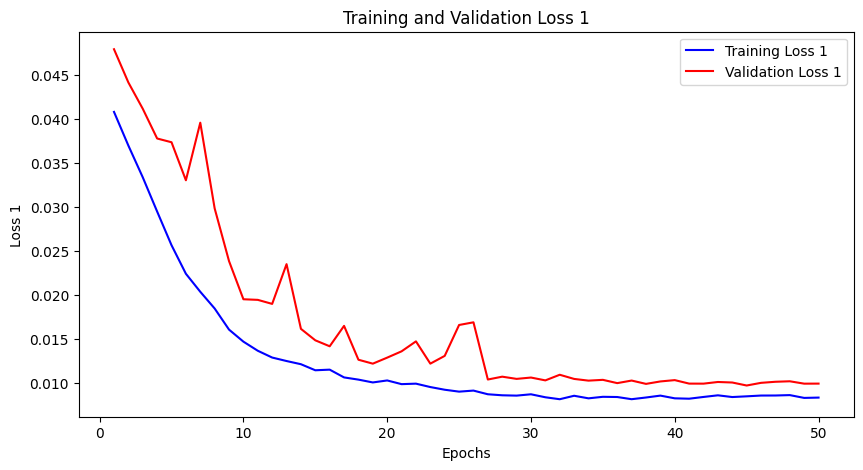

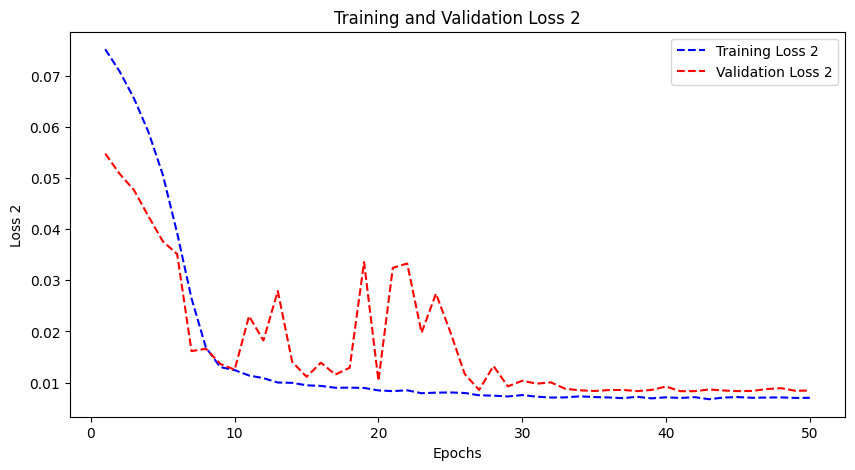

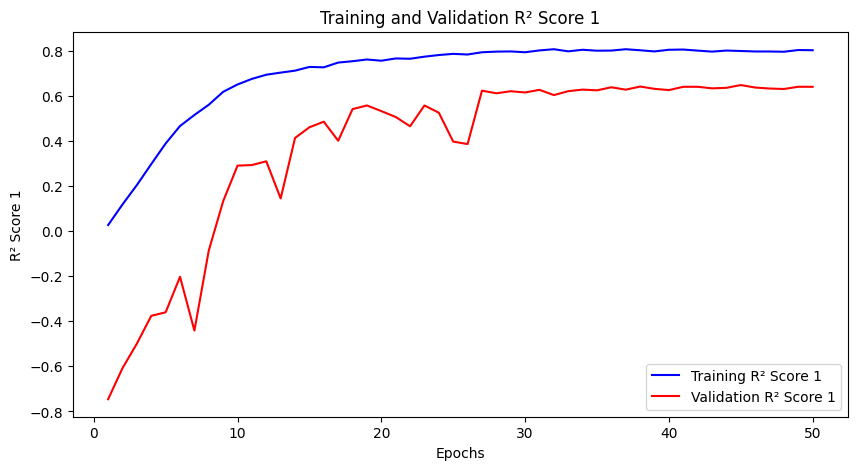

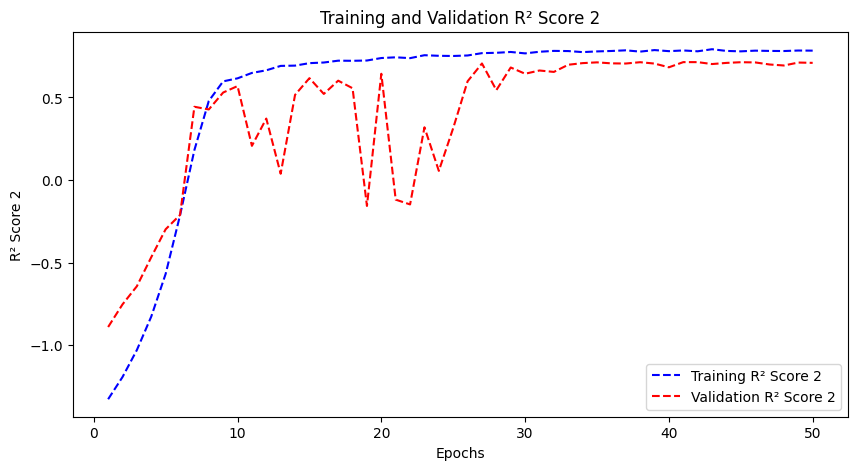

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming CNNRegressor, train_loader, val_loader, and other necessary elements are defined


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.counter = 0
        self.checkpoint_dir = 'checkpoints_CNN_multi_heads2'

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model and optimizer when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        self.val_loss_min = val_loss

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0
    all_outputs = []
    all_labels = []

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss1 = criterion(outputs[:, 0], labels[:, 0])
        loss2 = criterion(outputs[:, 1], labels[:, 1])
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss1 += loss1.item() * images.size(0)
        running_loss2 += loss2.item() * images.size(0)
        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    all_outputs = np.vstack(all_outputs)
    all_labels = np.vstack(all_labels)
    train_r2_score1 = r2_score(all_labels[:, 0], all_outputs[:, 0])
    train_r2_score2 = r2_score(all_labels[:, 1], all_outputs[:, 1])

    epoch_loss1 = running_loss1 / len(train_loader.dataset)
    epoch_loss2 = running_loss2 / len(train_loader.dataset)
    total_epoch_loss = epoch_loss1 + epoch_loss2

    return epoch_loss1, epoch_loss2, total_epoch_loss, (train_r2_score1, train_r2_score2)

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss1 = 0.0
    val_loss2 = 0.0
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), torch.stack(labels, dim=1).to(device)
            outputs = model(images)
            loss1 = criterion(outputs[:, 0], labels[:, 0])
            loss2 = criterion(outputs[:, 1], labels[:, 1])
            val_loss1 += loss1.item() * images.size(0)
            val_loss2 += loss2.item() * images.size(0)
            all_val_outputs.append(outputs.detach().cpu().numpy())
            all_val_labels.append(labels.cpu().numpy())

    all_val_outputs = np.vstack(all_val_outputs)
    all_val_labels = np.vstack(all_val_labels)
    val_r2_score1 = r2_score(all_val_labels[:, 0], all_val_outputs[:, 0])
    val_r2_score2 = r2_score(all_val_labels[:, 1], all_val_outputs[:, 1])

    val_loss1 /= len(val_loader.dataset)
    val_loss2 /= len(val_loader.dataset)
    total_val_loss = val_loss1 + val_loss2

    return val_loss1, val_loss2, total_val_loss, (val_r2_score1, val_r2_score2)

def plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    # Plot loss (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses1, 'b-', label='Training loss (Corn)')
    plt.plot(epochs, val_losses1, 'r-', label='Validation loss (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('loss (Corn)')
    plt.legend()
    plt.title('Training and Validation loss (Corn)')
    plt.savefig('checkpoints_CNN_multi_heads2/loss1.png')
    plt.show()
    
    # Plot Loss (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses2, 'b--', label='Training Loss (Soybeans)')
    plt.plot(epochs, val_losses2, 'r--', label='Validation Loss (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Soybeans)')
    plt.legend()
    plt.title('Training and Validation Loss (Soybeans)')
    plt.savefig('checkpoints_CNN_multi_heads2/loss2.png')
    plt.show()
    
    # Plot R² Score (Corn)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores1, 'b-', label='Training R² Score (Corn)')
    plt.plot(epochs, val_r2_scores1, 'r-', label='Validation R² Score (Corn)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Corn)')
    plt.legend()
    plt.title('Training and Validation R² Score (Corn)')
    plt.savefig('checkpoints_CNN_multi_heads2/r2_score1.png')
    plt.show()
    
    # Plot R² Score (Soybeans)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_r2_scores2, 'b--', label='Training R² Score (Soybeans)')
    plt.plot(epochs, val_r2_scores2, 'r--', label='Validation R² Score (Soybeans)')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score (Soybeans)')
    plt.legend()
    plt.title('Training and Validation R² Score (Soybeans)')
    plt.savefig('checkpoints_CNN_multi_heads2/r2_score2.png')
    plt.show()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNRegressor().double()
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    
    # Initialize learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    early_stopper = EarlyStopping(patience=15, verbose=True)

    num_epochs = 3
    train_losses1, train_losses2, train_losses = [], [], []
    val_losses1, val_losses2, val_losses = [],[],[]
    train_r2_scores1, train_r2_scores2 = [], []
    val_r2_scores1, val_r2_scores2 = [],[]

    with open('loss_log.txt', 'w') as f:
        f.write("Epoch,Training Loss 1,Training Loss 2,Total Training Loss,Training R^2 Score 1,Training R^2 Score (Soybeans),Validation Loss 1,Validation Loss 2,Total Validation Loss,Validation R^2 Score 1,Validation R^2 Score 2,Learning Rate\n")

        for epoch in range(num_epochs):
            try:
                train_loss1, train_loss2, train_loss, train_r2 = train_one_epoch(model, train_loader, criterion, optimizer, device)
                val_loss1, val_loss2, val_loss, val_r2 = validate_one_epoch(model, val_loader, criterion, device)

                train_losses1.append(train_loss1)
                train_losses2.append(train_loss2)
                train_losses.append(train_loss)
                val_losses1.append(val_loss1)
                val_losses2.append(val_loss2)
                val_losses.append(val_loss)
                train_r2_scores1.append(train_r2[0])
                train_r2_scores2.append(train_r2[1])
                val_r2_scores1.append(val_r2[0])
                val_r2_scores2.append(val_r2[1])

                # Get current learning rate
                current_lr = optimizer.param_groups[0]['lr']

                f.write(f"{epoch + 1},{train_loss1:.4f},{train_loss2:.4f},{train_loss:.4f},{train_r2[0]:.4f},{train_r2[1]:.4f},{val_loss1:.4f},{val_loss2:.4f},{val_loss:.4f},{val_r2[0]:.4f},{val_r2[1]:.4f},{current_lr:.6f}\n")

                print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss (Corn): {train_loss1:.4f}, Training Loss (Soybeans): {train_loss2:.4f}, Total Training Loss: {train_loss:.4f}, Training R^2 Score  (Corn): {train_r2[0]:.4f}, Training R^2 Score (Soybeans): {train_r2[1]:.4f}")
                print(f"Validation Loss (Corn): {val_loss1:.4f}, Validation Loss (Soybeans): {val_loss2:.4f}, Total Validation Loss: {val_loss:.4f}, Validation R^2 Score  (Corn): {val_r2[0]:.4f}, Validation R^2 Score (Soybeans): {val_r2[1]:.4f}")
                print(f"Learning Rate: {current_lr:.6f}")

                early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
                early_stopper(val_loss, model, optimizer, epoch)
                
                # Step the scheduler
                scheduler.step(val_loss)

                if early_stopper.early_stop:
                    print("Early stopping triggered.")
                    break
            except Exception as e:
                print(f"Exception occurred: {e}")
                early_stopper.save_checkpoint(val_loss, model, optimizer, epoch)
                break

    # Plot the metrics
    plot_metrics(train_losses1, train_losses2, val_losses1, val_losses2, train_r2_scores1, train_r2_scores2, val_r2_scores1, val_r2_scores2, num_epochs)

if __name__ == "__main__":
    main()


Test Loss (Corn): 0.0148, Test Loss (Soybeans): 0.0160, Total Test Loss: 0.0308
Test R^2 Score (Corn): 0.6745, Test R^2 Score (Soybeans): 0.3898


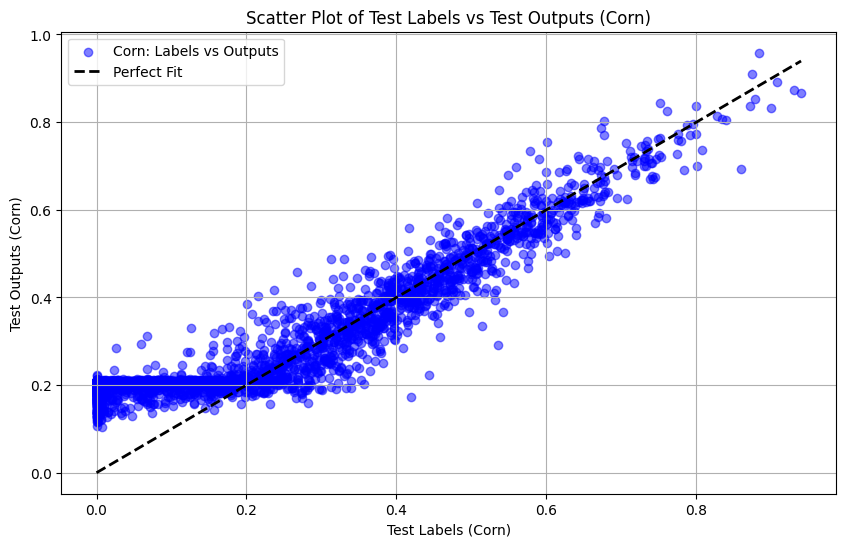

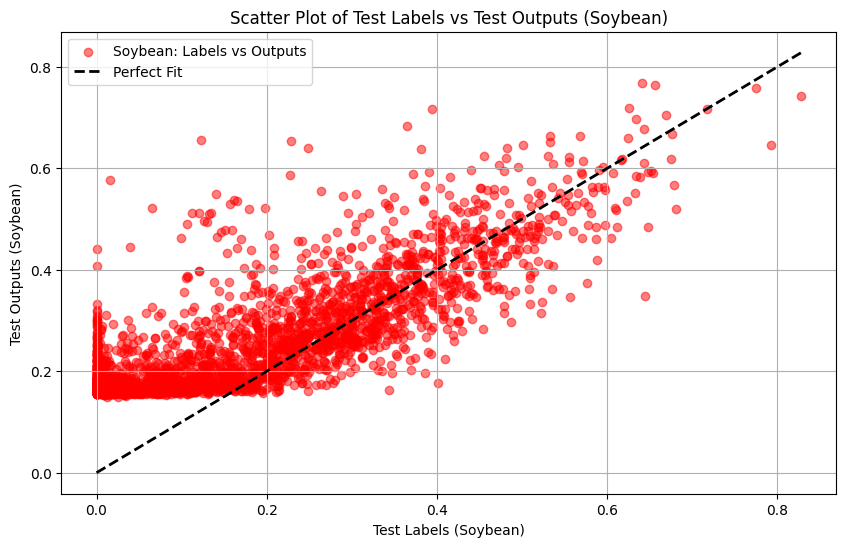

In [36]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

def plot_test_results(all_test_labels, all_test_outputs):
    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='blue', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig('checkpoints_CNN_multi_heads/test_labels_vs_outputs_corn.png')
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='red', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig('checkpoints_CNN_multi_heads/test_labels_vs_outputs_soybean.png')
    plt.show()


def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads/checkpoint_epoch_30.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))


In [15]:
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"
dataset_test = CropYieldDataset(img_test,crop_test, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)


Test Loss (Corn): 0.0152, Test Loss (Soybeans): 0.0115, Total Test Loss: 0.0267
Test R^2 Score (Corn): 0.6038, Test R^2 Score (Soybeans): 0.4230


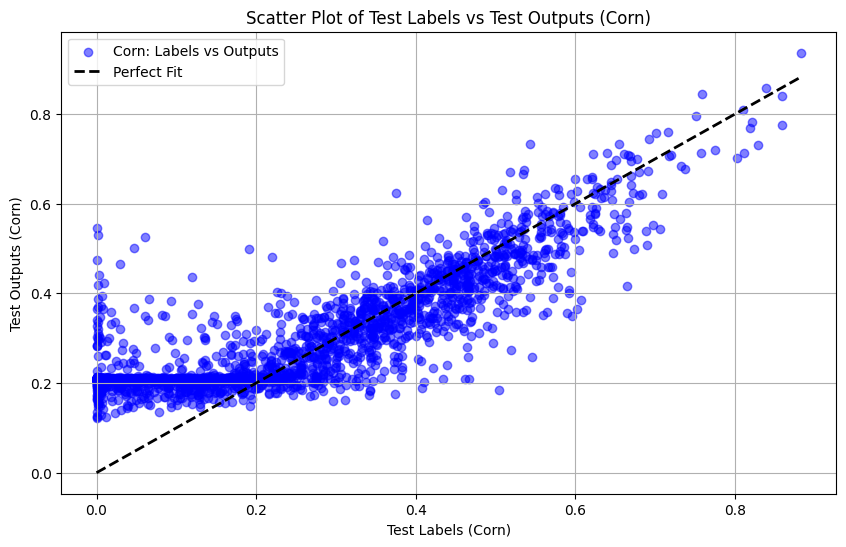

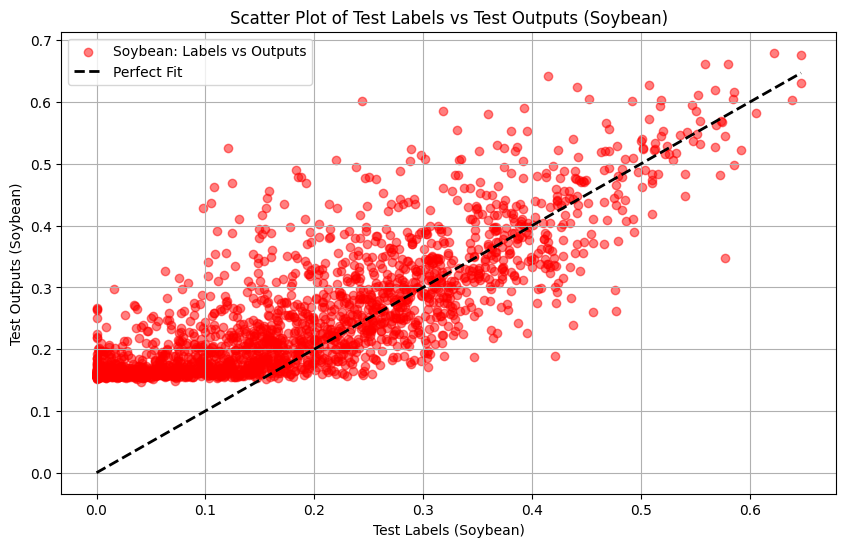

In [16]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the criterion and device
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode

    test_loss1 = 0.0
    test_loss2 = 0.0
    all_test_outputs = []
    all_test_labels = []

    with torch.no_grad():  # Ensure no gradients are computed in the testing phase
        for images, labels in test_loader:  # Iterate over batches of test data
            images, labels = images.to(device).float(), torch.stack(labels, dim=1).to(device).float()
            outputs = model(images)

            loss1 = criterion(outputs[:, 0], labels[:, 0])  # Compute loss for the first output
            loss2 = criterion(outputs[:, 1], labels[:, 1])  # Compute loss for the second output
            test_loss1 += loss1.item() * images.size(0)  # Accumulate the loss for the first output
            test_loss2 += loss2.item() * images.size(0)  # Accumulate the loss for the second output
            all_test_outputs.append(outputs.cpu().numpy())
            all_test_labels.append(labels.cpu().numpy())

    all_test_outputs = np.vstack(all_test_outputs)
    all_test_labels = np.vstack(all_test_labels)
    test_r2_score1 = r2_score(all_test_labels[:, 0], all_test_outputs[:, 0])
    test_r2_score2 = r2_score(all_test_labels[:, 1], all_test_outputs[:, 1])

    test_loss1 /= len(test_loader.dataset)  # Calculate average loss for the first output
    test_loss2 /= len(test_loader.dataset)  # Calculate average loss for the second output
    total_test_loss = test_loss1 + test_loss2  # Total test loss

    print(f"Test Loss (Corn): {test_loss1:.4f}, Test Loss (Soybeans): {test_loss2:.4f}, Total Test Loss: {total_test_loss:.4f}")
    print(f"Test R^2 Score (Corn): {test_r2_score1:.4f}, Test R^2 Score (Soybeans): {test_r2_score2:.4f}")

    return all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2

def plot_test_results(all_test_labels, all_test_outputs):
    labels_x = all_test_labels[:, 0]
    labels_y = all_test_labels[:, 1]
    outputs_x = all_test_outputs[:, 0]
    outputs_y = all_test_outputs[:, 1]

    # Plot for the first output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_x, outputs_x, color='blue', alpha=0.5, label='Corn: Labels vs Outputs')
    plt.plot([labels_x.min(), labels_x.max()], [labels_x.min(), labels_x.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Corn)')
    plt.xlabel('Test Labels (Corn)')
    plt.ylabel('Test Outputs (Corn)')
    plt.legend()
    plt.grid(True)
    plt.savefig('checkpoints_CNN_multi_heads/test_labels_vs_outputs_corn6.png')
    plt.show()

    # Plot for the second output
    plt.figure(figsize=(10, 6))
    plt.scatter(labels_y, outputs_y, color='red', alpha=0.5, label='Soybean: Labels vs Outputs')
    plt.plot([labels_y.min(), labels_y.max()], [labels_y.min(), labels_y.max()], 'k--', linewidth=2, label='Perfect Fit')
    plt.title('Scatter Plot of Test Labels vs Test Outputs (Soybean)')
    plt.xlabel('Test Labels (Soybean)')
    plt.ylabel('Test Outputs (Soybean)')
    plt.legend()
    plt.grid(True)
    plt.savefig('checkpoints_CNN_multi_heads/test_labels_vs_outputs_soybean6.png')
    plt.show()


def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

# Assuming 'test_loader' is defined, and the model is already loaded with the best weights
model = CNNRegressor().to(device)  # Use float tensors
checkpoint = torch.load('checkpoints_CNN_multi_heads/checkpoint_epoch_30.pth')
state_dict = remove_module_prefix(checkpoint['model_state_dict'])
model.load_state_dict(state_dict)

# Evaluate the model and plot the results
all_test_labels, all_test_outputs, test_loss1, test_loss2, total_test_loss, test_r2_score1, test_r2_score2 = evaluate_model(model, test_loader, criterion, device)
plot_test_results(np.array(all_test_labels), np.array(all_test_outputs))
